In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Bad key text.latex.unicode in file C:\Users\Sangwoo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\Sangwoo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\Sangwoo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplo

In [2]:
# 이미지 데이터 증강 라이브러리 및 이미지 read, resize
import imgaug as ia
from imgaug import augmenters as iaa
from skimage.io import imread
from skimage.transform import resize

In [3]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Add, Dropout
from tensorflow.keras.activations import softmax, sigmoid
from tensorflow.keras import regularizers
from keras.optimizers import adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.preprocessing import MultiLabelBinarizer
import keras.backend as K

Using TensorFlow backend.


# Parameter 설정 및 데이터 불러오기
   - 학습에 필요한 parameter 설정
   - 데이터 불러오기
   - 빈 값을 포함한 행 제거

In [4]:
# batch_size는 16, 데이터의 목표 갯수, train 85% test 15% 비율
batch_size = 16
target_num_samples = 25000
TRAIN_SAMPLE = 0.85

In [5]:
DATASET_PATH = os.path.join(os.getcwd(), 'input')
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [6]:
# 데이터 입력 및 Nan값을 포함한 행 제거
df = pd.read_csv(os.path.join(os.getcwd(), 'input', 'styles.csv'), error_bad_lines=False)
df = df.dropna()

C:\Users\Sangwoo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expe

# 데이터 정리 및 처리
   - 학습에 사용할 필요한 행들 추출 -> 특징 추출
   - 데이터 불균형 해결 -> 너무 적은 data들은 제거 + 데이터 증강 기법 + downsampling 기법
   - dataframe에 이미지 데이터 경로 attribute 추가

In [7]:
# 필요한 행들만 추출 -> 특징 추출
labels_df = df[['id', 'subCategory', 'articleType', 'season', 'usage']]

# 해당 옷을 입는 계절과 스타일을 하나의 attribute으로 합침 (묶어서 보는 것이 맞다고 생각)
labels_df['attributes'] = labels_df[['season', 'usage']].values.tolist()
print(labels_df)

          id subCategory            articleType  season   usage  \
0      15970     Topwear                 Shirts    Fall  Casual   
1      39386  Bottomwear                  Jeans  Summer  Casual   
2      59263     Watches                Watches  Winter  Casual   
3      21379  Bottomwear            Track Pants    Fall  Casual   
4      53759     Topwear                Tshirts  Summer  Casual   
...      ...         ...                    ...     ...     ...   
44419  17036       Shoes           Casual Shoes  Summer  Casual   
44420   6461  Flip Flops             Flip Flops  Summer  Casual   
44421  18842     Topwear                Tshirts    Fall  Casual   
44422  46694   Fragrance  Perfume and Body Mist  Spring  Casual   
44423  51623     Watches                Watches  Winter  Casual   

             attributes  
0        [Fall, Casual]  
1      [Summer, Casual]  
2      [Winter, Casual]  
3        [Fall, Casual]  
4      [Summer, Casual]  
...                 ...  
44419  [Summe

C:\Users\Sangwoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
# subCatergory의 attributes
# data들이 매우 불균형한 것을 확인할 수 있음
subCategory = labels_df.subCategory.value_counts()
print(subCategory)

C:\Users\Sangwoo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Topwear                     15387
Shoes                        7323
Bags                         3053
Bottomwear                   2686
Watches                      2542
Innerwear                    1806
Jewellery                    1079
Eyewear                      1073
Fragrance                    1001
Sandal                        961
Wallets                       925
Flip Flops                    913
Belts                         811
Socks                         698
Dress                         478
Loungewear and Nightwear      464
Saree                         427
Lips                          425
Headwear                      293
Nails                         278
Makeup                        263
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin                           53
Skin Care     

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [9]:
# 너무 적은 data를 가진 attributes은 제거 -> 데이터 불균형 해결 (1)
subCategory = labels_df['subCategory'].value_counts()

indexes = subCategory.index
values = subCategory.values
for i in range(len(subCategory)):
    if subCategory[i] < 500:
        break

types_used = indexes[:i]
print('subCategory types used: ',types_used)

subCategory types used:  Index(['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches', 'Innerwear',
       'Jewellery', 'Eyewear', 'Fragrance', 'Sandal', 'Wallets', 'Flip Flops',
       'Belts', 'Socks'],
      dtype='object')


In [10]:
# 너무 적은 data를 가진 attributes 제거 -> 데이터 증강을 여러번 하여 수를 늘리는 것은 학습에 나쁜 성능을 초래
labels_df = labels_df[labels_df['subCategory'].isin(types_used)]
print(labels_df)

          id subCategory            articleType  season   usage  \
0      15970     Topwear                 Shirts    Fall  Casual   
1      39386  Bottomwear                  Jeans  Summer  Casual   
2      59263     Watches                Watches  Winter  Casual   
3      21379  Bottomwear            Track Pants    Fall  Casual   
4      53759     Topwear                Tshirts  Summer  Casual   
...      ...         ...                    ...     ...     ...   
44419  17036       Shoes           Casual Shoes  Summer  Casual   
44420   6461  Flip Flops             Flip Flops  Summer  Casual   
44421  18842     Topwear                Tshirts    Fall  Casual   
44422  46694   Fragrance  Perfume and Body Mist  Spring  Casual   
44423  51623     Watches                Watches  Winter  Casual   

             attributes  
0        [Fall, Casual]  
1      [Summer, Casual]  
2      [Winter, Casual]  
3        [Fall, Casual]  
4      [Summer, Casual]  
...                 ...  
44419  [Summe

In [11]:
# 500 이상 1000개 미만인 data들의 데이터 증강을 위해 list에 저장
subCategory = labels_df['subCategory'].value_counts()

indexes = subCategory.index
values = subCategory.values
val_1000_less = []
for i in range(len(subCategory)):
    if subCategory[i] < 1000:
        val_1000_less.append(indexes[i])

In [12]:
# 증강시킬 subCategory attributes
print(val_1000_less)

['Sandal', 'Wallets', 'Flip Flops', 'Belts', 'Socks']


In [13]:
# articleType의 attributes
# data들이 매우 불균형한 것을 확인할 수 있음
articleType = labels_df.articleType.value_counts()
print(articleType)

Tshirts             7066
Shirts              3214
Casual Shoes        2845
Watches             2542
Sports Shoes        2016
                    ... 
Trolley Bag            3
Tablet Sleeve          3
Dresses                2
Suits                  1
Travel Accessory       1
Name: articleType, Length: 79, dtype: int64


In [14]:
# 너무 적은 data를 가진 attributes은 제거 -> 데이터 불균형 해결 (1)
articleType = labels_df['articleType'].value_counts()

indexes = articleType.index
values = articleType.values
for i in range(len(articleType)):
    if articleType[i] < 500:
        break

types_used = indexes[:i]
print('Article types used: ',types_used)

Article types used:  Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes',
       'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets',
       'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks',
       'Formal Shoes', 'Jeans', 'Perfume and Body Mist', 'Shorts', 'Trousers',
       'Flats'],
      dtype='object')


In [15]:
# 너무 적은 data를 가진 attributes 제거 -> 데이터 증강을 여러번 하여 수를 늘리는 것은 학습에 나쁜 성능을 초래
labels_df = labels_df[labels_df['articleType'].isin(types_used)]
print(labels_df)

          id subCategory            articleType  season   usage  \
0      15970     Topwear                 Shirts    Fall  Casual   
1      39386  Bottomwear                  Jeans  Summer  Casual   
2      59263     Watches                Watches  Winter  Casual   
4      53759     Topwear                Tshirts  Summer  Casual   
5       1855     Topwear                Tshirts  Summer  Casual   
...      ...         ...                    ...     ...     ...   
44419  17036       Shoes           Casual Shoes  Summer  Casual   
44420   6461  Flip Flops             Flip Flops  Summer  Casual   
44421  18842     Topwear                Tshirts    Fall  Casual   
44422  46694   Fragrance  Perfume and Body Mist  Spring  Casual   
44423  51623     Watches                Watches  Winter  Casual   

             attributes  
0        [Fall, Casual]  
1      [Summer, Casual]  
2      [Winter, Casual]  
4      [Summer, Casual]  
5      [Summer, Casual]  
...                 ...  
44419  [Summe

In [16]:
articleType = labels_df['articleType'].value_counts()

indexes = articleType.index
values = articleType.values
art_1000_less = []
for i in range(len(articleType)):
    if articleType[i] < 1000:
        art_1000_less.append(indexes[i])

In [17]:
print(art_1000_less)

['Wallets', 'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks', 'Formal Shoes', 'Jeans', 'Perfume and Body Mist', 'Shorts', 'Trousers', 'Flats']


In [18]:
# 하위 폴더에 있는 모든 이미지의 파일 경로 가져오기
image_base_dir = os.path.join(os.getcwd(), 'input', 'images')
image_fnames = [f for f in glob.glob(image_base_dir + "**/*.jpg", recursive=True)]

# id와 이미지의 파일명과 동일
image_ids = [int(f.split('\\')[-1][:-4]) for f in image_fnames]

image_ids_df = pd.DataFrame({'id':image_ids,'fname':image_fnames}, index=None)

# 이미지와 라벨이 모두 있는지 확인하기 위한 내부 결합
labels_df = labels_df.merge(image_ids_df, how='inner', on='id')

labels_df.reset_index(drop='index', inplace=True)

In [19]:
labels_df

id subCategory            articleType  season   usage  \
0      15970     Topwear                 Shirts    Fall  Casual   
1      39386  Bottomwear                  Jeans  Summer  Casual   
2      59263     Watches                Watches  Winter  Casual   
3      53759     Topwear                Tshirts  Summer  Casual   
4       1855     Topwear                Tshirts  Summer  Casual   
...      ...         ...                    ...     ...     ...   
34649  17036       Shoes           Casual Shoes  Summer  Casual   
34650   6461  Flip Flops             Flip Flops  Summer  Casual   
34651  18842     Topwear                Tshirts    Fall  Casual   
34652  46694   Fragrance  Perfume and Body Mist  Spring  Casual   
34653  51623     Watches                Watches  Winter  Casual   

             attributes                                              fname  
0        [Fall, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\159...  
1      [Summer, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\393...  
2      [Winter, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\592...  
3      [Summer, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\537...  
4      [Summer, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\185...  
...                 ...                                                ...  
34649  [Summer, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\170...  
34650  [Summer, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\646...  
34651    [Fall, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\188...  
34652  [Spring, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\466...  
34653  [Winter, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\516...  

[34654 rows x 7 columns]

In [20]:
import cv2

# 데이터 증강
   - data 수가 너무 적은 것은 증강을 여러번 진행해야하는데 그렇게 되면 학습에 영향
   - 데이터 불균형을 해소하기 위해 data 수가 부족한 attribute에만 데이터 증강시킴
   - 적은 수의 dataset을 효율적으로 사용하기 위한 기법

In [21]:
# 이미지 증강 -> 데이터 불균형 해결 (2)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # 50%를 수평으로 뒤집기
    iaa.GammaContrast((0.5, 2.0)), # gamma에 따라 영상의 대비를 수정, 감마는 [0.5, 2.0] 간격에서 균일하게 샘플링
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5)) # 50%의 확률로 0에서 0.5의 시그마로 이미지를 blur처리
    ),
    iaa.Affine( # Affine 변환 중 원하는 작업 종류와 정도를 설정
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale 정도를 범위로 지정해주면 inference 할 때마다 범위 내의 값 중 하나로 random하게 진행
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # -20 ~ 20%로 x, y축 이동
        rotate=(-45, 45), # 회전
        shear=(-16, 16), # 깍기
        order=[0, 1], # 가장 가까운 이웃 또는 이중선 보간법 사용
        cval=(0, 255), # 0 ~ 255
    )])

In [22]:
# subCategory의 data가 500개 이상 1000개 미만 attributes 데이터 증강 적용 후 dataframe에 추가
for i in range(len(labels_df)):
    for c in val_1000_less:
        index = 999
        tmp = {}
        if labels_df.subCategory[i] == c:
            temp = labels_df.loc[i]
            new_img = seq(image=cv2.imread(temp[6]))
            cv2.imwrite(os.path.join(os.getcwd(), 'input', 'images', str(temp[0]) + str(index) + '.jpg'), new_img)
            temp[0] = int(str(temp[0]) + str(index))
            temp[6] = os.path.join(os.getcwd(), 'input', 'images', str(temp[0]) + str(index) + '.jpg')
            tmp['id'] = temp[0]
            tmp['subCategory'] = temp[1]
            tmp['articleType'] = temp[2]
            tmp['season'] = temp[3]
            tmp['usage'] = temp[4]
            tmp['attributes'] = temp[5]
            tmp['fname'] = temp[6]
            labels_df = labels_df.append(pd.Series(tmp, index=labels_df.columns), ignore_index=True)

C:\Users\Sangwoo\Anaconda3\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [23]:
# 데이터 증강이 적용 후
labels_df.subCategory.value_counts()

Topwear       13885
Shoes          7323
Watches        2542
Bags           2481
Wallets        1850
Flip Flops     1826
Sandal         1788
Bottomwear     1677
Belts          1622
Socks          1372
Eyewear        1073
Innerwear       847
Fragrance       597
Name: subCategory, dtype: int64

In [24]:
# articleType의 data가 500개 이상 1000개 미만 attributes 데이터 증강 적용 후 dataframe에 추가
for i in range(len(labels_df)):
    for c in art_1000_less:
        index = 999
        tmp = {}
        if labels_df.articleType[i] == c:
            try:
                temp = labels_df.loc[i]
                new_img = seq(image=cv2.imread(temp[6]))
                cv2.imwrite(os.path.join(os.getcwd(), 'input', 'images', str(temp[0]) + str(index) + '.jpg'), new_img)
                temp[0] = int(str(temp[0]) + str(index))
                temp[6] = os.path.join(os.getcwd(), 'input', 'images', str(temp[0]) + str(index) + '.jpg')
                tmp['id'] = temp[0]
                tmp['subCategory'] = temp[1]
                tmp['articleType'] = temp[2]
                tmp['season'] = temp[3]
                tmp['usage'] = temp[4]
                tmp['attributes'] = temp[5]
                tmp['fname'] = temp[6]
                labels_df = labels_df.append(pd.Series(tmp, index=labels_df.columns), ignore_index=True)
            except:
                continue

In [25]:
# 데이터 증강이 적용 후
labels_df.articleType.value_counts()

Tshirts                  7066
Shirts                   3212
Casual Shoes             2845
Wallets                  2779
Flip Flops               2742
Sandals                  2683
Watches                  2542
Belts                    2436
Socks                    2058
Sports Shoes             2016
Kurtas                   1844
Tops                     1762
Handbags                 1757
Briefs                   1694
Backpacks                1444
Heels                    1323
Formal Shoes             1274
Jeans                    1204
Perfume and Body Mist    1194
Shorts                   1090
Sunglasses               1073
Trousers                 1060
Flats                    1000
Name: articleType, dtype: int64

# Downsampling 적용
   - 데이터의 분포가 한 쪽으로 치우친 경우 사용하는 기법
   - 클래스의 평균을 구해 평균보다 5배를 초과하지 않도록 제한
   - 즉, 데이터 수가 많든 적든 균등하게 적용이 가능 -> 적은 수의 데이터셋을 최대의 효율을 가져오기 위해 전에 데이터 증강을 통해 클래스의 평균을 높였으며, 한 클래스의 data 수도 증가
   - 한 클래스의 data 수를 최대 target_num_samples(25000)로 지정

In [26]:
# downsampling 기법 적용 -> 데이터 불균형 해결 (3)
if target_num_samples is not None:
    # 클래스 1개가 평균 클래스 크기의 5배를 초과하지 않도록 클래스 제한
    max_category_num = int(4 * np.mean(labels_df.subCategory.value_counts().values))
    labels_df = labels_df.groupby('subCategory', group_keys=False).apply(
        lambda x: x.sample(min(len(x), max_category_num),
                           random_state=42))

    # 샘플의 목표 수를 가져오는 데 필요한 총 데이터 세트의 비율 계산 또한 이 값이 1을 초과하지 않도록 한다
    downsample_proportion = min(1, target_num_samples / labels_df.shape[0])

    # downsampling 기법 적용
    labels_df = labels_df.groupby('subCategory', group_keys=False).apply(
        lambda x: x.sample(int(len(x) * downsample_proportion),
                           random_state=42))

# dataframe Shuffle
labels_df = labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
print(labels_df)

             id subCategory            articleType  season   usage  \
0      44075999   Fragrance  Perfume and Body Mist  Spring  Casual   
1      58635999       Socks                  Socks  Summer  Sports   
2         43241       Shoes           Sports Shoes  Summer  Sports   
3         29708     Topwear                 Shirts  Summer  Formal   
4         32403     Topwear                   Tops  Summer  Casual   
...         ...         ...                    ...     ...     ...   
24989     49775     Topwear                 Kurtas  Summer  Ethnic   
24990  16236999  Flip Flops             Flip Flops    Fall  Casual   
24991     54031        Bags               Handbags  Summer  Casual   
24992     24550     Topwear                   Tops    Fall  Ethnic   
24993     52776     Wallets                Wallets    Fall  Casual   

             attributes                                              fname  
0      [Spring, Casual]  C:\Users\Sangwoo\Desktop\code\input\images\440...  
1    

# 사용자 정의 ImageDataGenerator
   - tensorflow, keras에서 제공하는 ImageDataGenerator는 서로 연관된 계층적인 클래스를 나눠 구분이 불가능하여 따로 정의를 하여 구현
   - ImageDataGenerator와 똑같이 구현 -> 여러 클래스를 batch_size만큼 나눠 학습이 진행 가능하도록 함
   - Image의 크기가 작기 때문에 나중에 사용할 MobilNetV2의 input size(96, 96, 3)에 맞게 resize (최대한 비슷한 크기로 하는 것이 학습에 좋음)

In [28]:
class FashionSequence(Sequence):
    def __init__(self, x_set, y_cat, y_subcat, y_attr, batch_size, augmentations=None):
        self.x = x_set
        self.y_cat = y_cat
        self.y_subcat = y_subcat
        self.y_attr = y_attr
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / int(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_cat = self.y_cat[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_subcat = self.y_subcat[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_attr = self.y_attr[idx * self.batch_size:(idx + 1) * self.batch_size]

        if self.augment == None:
            return np.array([
                resize(imread(file_name), (96, 96, 3)) / 255.0
                for file_name in batch_x]), [batch_y_cat, batch_y_subcat, batch_y_attr]
        else:
            return np.array([
                self.augment(image=resize(imread(file_name), (96, 96, 3))) / 255.0
                for file_name in batch_x]), [batch_y_cat, batch_y_subcat, batch_y_attr]

In [29]:
num_samples = len(image_fnames)

num_samples_train = int(num_samples * TRAIN_SAMPLE)
num_samples_test = num_samples - num_samples_train

print(f"{num_samples_train} training and {num_samples_test} testing samples")

45610 training and 8049 testing samples


In [30]:
# subCategory labels 가져오기
cat_names = pd.Categorical(labels_df.subCategory).categories
cat_labels_all = to_categorical(pd.Categorical(labels_df.subCategory).codes)
num_categories = cat_labels_all.shape[1]


# articleType labels 가져오기
subcat_names = pd.Categorical(labels_df.articleType).categories
subcat_labels_all = to_categorical(pd.Categorical(labels_df.articleType).codes)
num_subcats = subcat_labels_all.shape[1]


# attributes labels 가져오기
all_attributes = labels_df.attributes.values
attributes_set = list(set(list(labels_df.season) + list(labels_df.usage)))

# 여러 클래스가 있는 attributes 속성을 multi-label encoding 수행
mlb = MultiLabelBinarizer(classes=attributes_set)
mlb.fit([tuple(f) for f in all_attributes])
attribute_labels_all = mlb.transform(all_attributes)

attribute_names = mlb.classes_
num_attributes = attribute_labels_all.shape[1]

In [31]:
print(f"{num_categories} categories and {num_subcats} subcategories")
print(f"{num_attributes} possible attributes")
print(f"Possible attributes: {mlb.classes_}")

13 categories and 23 subcategories
11 possible attributes
Possible attributes: ['Formal' 'Fall' 'Ethnic' 'Summer' 'Sports' 'Smart Casual' 'Party'
 'Casual' 'Spring' 'Travel' 'Winter']


In [32]:
# 범주별로 계층화된 train 및 test sample 인덱스 가져오기
train_indices = sorted(list(labels_df.groupby('subCategory', group_keys=False).apply(lambda x: x.sample(int(len(x)*TRAIN_SAMPLE), random_state=42)).index))
test_indices = [x for x in list(labels_df.index) if x not in train_indices]

# Train test split
   - train set 비율 : 85%, test set 비율 : 15%
   - index값을 가져와 train dataset, test dataset 저장

In [33]:
cat_labels_train = cat_labels_all[train_indices]
subcat_labels_train = subcat_labels_all[train_indices]
attribute_labels_train = attribute_labels_all[train_indices]


cat_labels_test = cat_labels_all[test_indices]
subcat_labels_test = subcat_labels_all[test_indices]
attribute_labels_test = attribute_labels_all[test_indices]

img_list_train = list(np.array(image_fnames)[train_indices])
img_list_test = list(np.array(image_fnames)[test_indices])

# ImageDataGenerator 생성
   - 아까 정의한 FashionSequence를 생성하여 학습을 할 수 있는 객체로 변환
   - 입력 x : image data, 클래스 y : subCategory, articleType, [season, casual]
   - 데이터 증강 한번 더 적용
   - batch_size : 16

In [34]:
train_generator = FashionSequence(x_set = img_list_train,
                                  y_cat = cat_labels_train,
                                  y_subcat = subcat_labels_train,
                                  y_attr = attribute_labels_train,
                                  batch_size = batch_size,
                                  augmentations=seq)

test_generator = FashionSequence(x_set = img_list_test,
                                  y_cat = cat_labels_test,
                                  y_subcat = subcat_labels_test,
                                  y_attr = attribute_labels_test,
                                  batch_size = batch_size,
                                  augmentations=seq)

# 모델 구현
   - [논문 참고] https://arxiv.org/abs/1806.09445
   - 논문에서는 pre-trained ResNet50을 사용했지만 개인 노트북으로는 학습 진행이 너무 오래걸리는 관계로 경량화된 MobileNetV2 모델을 사용
   - 다른 모델들의 input size는 지금 사용하고 있는 image data size보다 훨씬 크다 -> MobileNetV2는 크기가 비슷한 (96, 96, 3)으로 진행한 pre-trained 모델이 있음
   - MobileNetV2 모델은 가장 연산량을 요구하는 convolution filer 연산을 줄여 경량화된 모델이다. 정확도는 유지하면서 다양한 경량 디바이스 (ex 모바일)에서 내장하여 추론을 가능하게 하는 기술 (최근에 많이 사용하고 있는 경량화 기술)
   - Transfer learning을 통해 기존 MobileNetV2의 구조와 가중치를 고정한 채로 학습 진행
   - MobileNetV2 모델에서 subCategory, articleType, attributes을 classify하기 위해 따로 classifcation layer 구현
   - subCategory -> articleType -> attributes 순으로 순전파 구현
   - 반대로 attributes -> articleType -> subCategoty 순으로 역전파 구현
   - 그렇게 구현한 이유 : 계층적인 구조처럼 subCategory가 큰 구조라 생각했고, 그 subCategory에서 articleType로 구분이 가능하다고 생각을 했고, 마지막으로 articleType으로 attributes을 구분할 수 있다고 생각했으며, 또 반대로도 판별이 가능하다고 생각했습니다. 즉 서로 다 연관되어 한 속성을 통해서 다른 속성을 알 수 있다고 생각했습니다.
   - 출력 layer : subCategory, articleType의 활성화 함수를 softmax, attributes의 활성화 함수를 sigmoid
   - 이유 : subCategory, articleType은 binary가 아닌 categorical로 진행이 되고, attributes은 아까 MultiLabelBinarizer로 통해 클래스를 0과1인 binary로 진행

In [35]:
base_model = MobileNetV2(input_shape=(96, 96, 3), weights='imagenet')

# 논문 참고하여 구현
x_cat = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(base_model.output)
x_subcat = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(base_model.output)
x_attr = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(base_model.output)


# 순전파 구현
dense_1 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_cat)
dense_cat_b= Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_1)
dense_cat_b = Dropout(0.5)(dense_cat_b)

dense_2 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_subcat)
dense_3 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_cat_b)
add_1 = Add()([dense_2, dense_3])
dense_subcat_b = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(add_1)
dense_subcat_b = Dropout(0.5)(dense_subcat_b)

dense_4 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_attr)
dense_5 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_cat_b)
add_2 = Add()([dense_4, dense_5])
dense_attr_b = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(add_2)
dense_attr_b = Dropout(0.5)(dense_attr_b)


# 역전파 진행
dense_6 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_attr)
dense_attr_g = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_6)
dense_attr_g = Dropout(0.5)(dense_attr_g)

dense_7 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_subcat)
dense_subcat_g = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_7)
dense_subcat_g = Dropout(0.5)(dense_subcat_g)

dense_8 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x_cat)
dense_9 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_subcat_g)
dense_10 = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(dense_attr_g)
add_3 = Add()([dense_9, dense_10])
add_4 = Add()([dense_8, add_3])
dense_cat_g = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(add_4)
dense_cat_g = Dropout(0.5)(dense_cat_g)


add_cat = Add()([dense_cat_b, dense_cat_g])
cat_out = Dense(units=num_categories, activation='softmax', kernel_regularizer=regularizers.l2(0.0005), name="subCategory_output")(add_cat)

add_subcat = Add()([dense_subcat_b, dense_subcat_g])
subcat_out = Dense(units=num_subcats, activation='softmax', kernel_regularizer=regularizers.l2(0.0005), name="articleType_output")(add_subcat)

add_attr = Add()([dense_attr_b, dense_attr_g])
attr_out = Dense(units=num_attributes, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0005), name="Attributes_output")(add_attr)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [36]:
model = Model(inputs=base_model.input, outputs=[cat_out, subcat_out, attr_out])

In [37]:
# optimizer
opt = adam(lr=0.001)

# loss functions
losses = {'subCategory_output':'categorical_crossentropy',
         'articleType_output':'categorical_crossentropy',
         'Attributes_output':'binary_crossentropy'}

In [38]:
# evaluation functions
metrics = {"subCategory_output":"categorical_accuracy",
          "articleType_output":"categorical_accuracy",
          "Attributes_output":"top_k_categorical_accuracy"}

In [39]:
model.compile(optimizer=opt, loss=losses, metrics=metrics)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [41]:
# 모델의 구조와 가중치 저장
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'models', '{epoch:02d}-loss-{val_loss:.2f}.h5'), monitor='val_loss', save_best_only = True)

# 학습 진행 상황을 그래프 형태로 볼 수 있게 Tensorboard 구현
tb_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), 'logs'), 
                          histogram_freq=0, 
                          batch_size=batch_size, 
                          update_freq=2048,
                          write_grads=True,
                          write_images=True)

C:\Users\Sangwoo\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 모델 학습
   - epoch은 25로 진행
   - 아까 생성한 train_generator와 test_generator 사용

In [42]:
# model 학습
model.fit_generator(train_generator,
                    steps_per_epoch=None,
                    epochs=25,
                    verbose=1,
                    callbacks=[checkpoint_callback, tb_callback],
                    validation_data=test_generator,
                    validation_steps=None,
                    shuffle=True)




Epoch 1/25
 128/1328 [=>............................] - ETA: 4:26 - loss: 6.7237 - subCategory_output_loss: 2.2981 - articleType_output_loss: 3.0283 - Attributes_output_loss: 0.3507 - subCategory_output_categorical_accuracy: 0.2925 - articleType_output_categorical_accuracy: 0.1528 - Attributes_output_top_k_categorical_accuracy: 0.8999  ETA: 29:35 - loss: 8.7405 - subCategory_output_loss: 2.5173 - articleType_output_loss: 3.1166 - Attributes_output_loss: 0.6669 - subCategory_output_categorical_accuracy: 0.2778 - articleType_output_categorical_accuracy: 0.1042 - Attributes_output_top_k_cate - ETA: 13:49 - loss: 8.1776 - subCategory_output_loss: 2.4143 - articleType_output_loss: 3.0830 - Attributes_output_loss: 0.5451 - subCategory_output_categorical_accWARNING:tensorflow:From C:\Users\Sangwoo\Anaconda3\lib\site-packages\keras\callbacks\tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

1328/1328 [==============================] - 279s 2

1328/1328 [==============================] - 262s 198ms/step - loss: 5.5536 - subCategory_output_loss: 2.2571 - articleType_output_loss: 3.0038 - Attributes_output_loss: 0.2898 - subCategory_output_categorical_accuracy: 0.2889 - articleType_output_categorical_accuracy: 0.1430 - Attributes_output_top_k_categorical_accuracy: 0.9155 - val_loss: 5.4523 - val_subCategory_output_loss: 2.2565 - val_articleType_output_loss: 2.9979 - val_Attributes_output_loss: 0.2847 - val_subCategory_output_categorical_accuracy: 0.2884 - val_articleType_output_categorical_accuracy: 0.1451 - val_Attributes_output_top_k_categorical_accuracy: 0.9119ributes_output_loss: 0.2904 - subCategory_output_categorical_accuracy: 0.2985 - articleType_output_categorical_accuracy: 0.1443 - Attributes_output_top_k_ - ETA: 3:26 - loss: 5.5400 - subCategory_output_loss: 2.2483 - articleType_output_loss: 2.9980 - Attributes_output_loss: 0.2907 - subCategory_out - ETA: 2:50 - loss: 5.5359 - subCategory_output_loss: 2.2450 - articl

# 모델 평가
   - train set에서의 loss, accuracy 전체 출력
   - test set에서의 loss, accuracy 전체 출력

In [43]:
for k in model.history.history.keys():
    print (f"{k}:  {model.history.history[k]}")

val_loss:  [5.473043441772461, 5.410303115844727, 5.458184242248535, 5.444590091705322, 5.435237407684326, 5.4128031730651855, 5.407434463500977, 5.4363179206848145, 5.411994457244873, 5.42535400390625, 5.451210021972656, 5.39433479309082, 5.4469218254089355, 5.446591377258301, 5.411698341369629, 5.419249534606934, 5.421266555786133, 5.45229959487915, 5.424715042114258, 5.41347074508667, 5.427533149719238, 5.415166854858398, 5.4304070472717285, 5.427228927612305, 5.4262542724609375]
val_subCategory_output_loss:  [2.259610891342163, 2.2576956748962402, 2.257418394088745, 2.2573304176330566, 2.2578113079071045, 2.256471872329712, 2.25628662109375, 2.256483316421509, 2.257025957107544, 2.257789373397827, 2.256570339202881, 2.256715774536133, 2.2575137615203857, 2.2577106952667236, 2.256547451019287, 2.2567813396453857, 2.256544828414917, 2.256476640701294, 2.256636381149292, 2.256621837615967, 2.2565860748291016, 2.2566792964935303, 2.25630521774292, 2.2561099529266357, 2.2560770511627197

In [44]:
# test set을 통해 predict
predictions = model.predict_generator(test_generator)

# 모델 예측한 결과 시각화
   - test dataset의 image data를 입력으로 줘 예측한 결과 시각화
   - 좋은 정확도를 보여주지 못함 (subCategory 약 30% articleType 약 15% attributes 약 92%의 정확도)
   - 높은 성능을 보여주지 못한 이유 : 
       - 1. 더 복잡한 모델 필요 -> 논문에서는 ResNet50 모델 사용 
       - 2. 계층적인 구조를 가진 클래스들의 상관관계 파악 미흡 
       - 3. 적은 dataset의 수를 억지로 늘릴려고 데이터 증강을 여러번 진행 (2~3번)
       - 4. 데이터 불균형을 해소하기 위해 여러가지 방법을 사용했지만 아직도 데이터가 불균형하다

Input image 0:


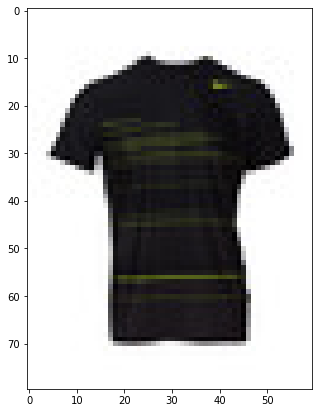

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 1:


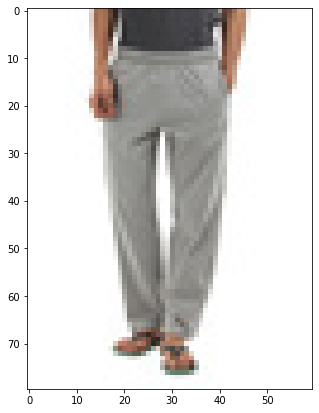

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 2:


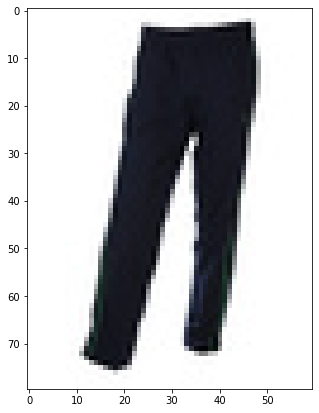

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 3:


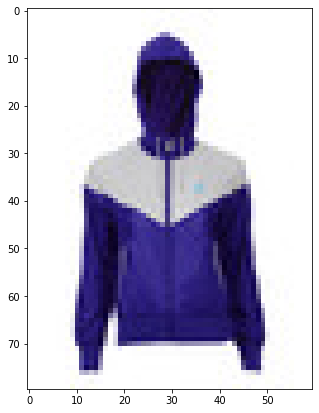

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 4:


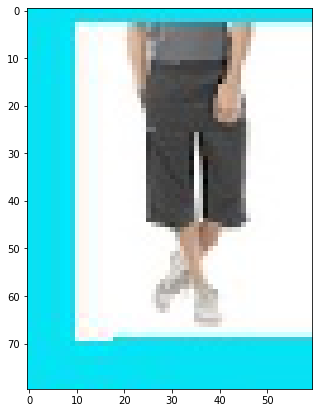

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 5:


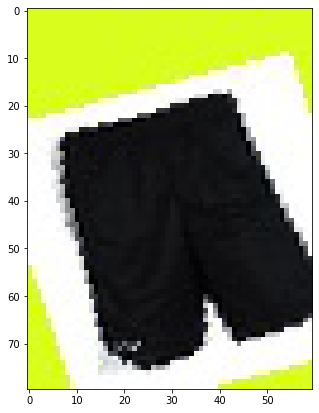

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 6:


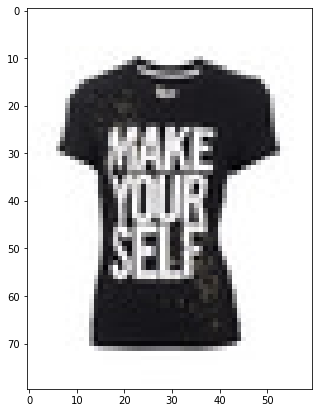

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 7:


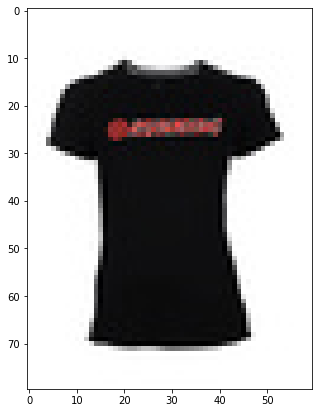

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 8:


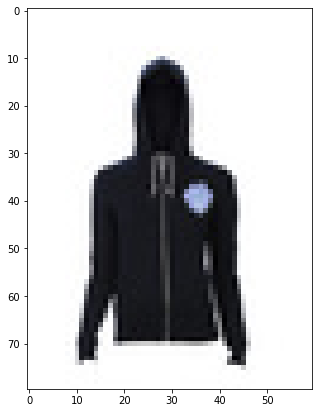

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 9:


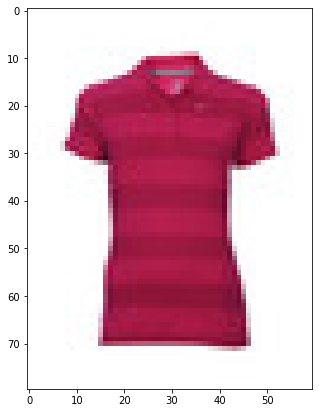

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 10:


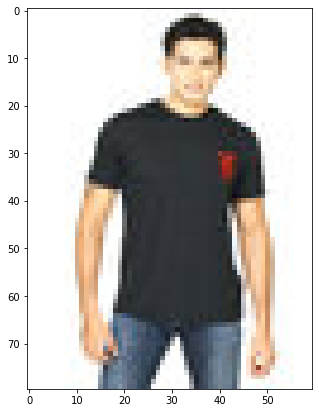

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 11:


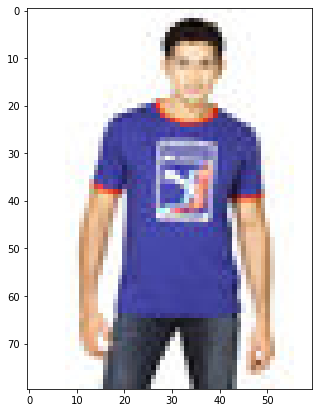

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 12:


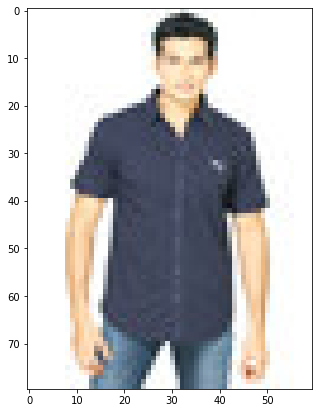

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 13:


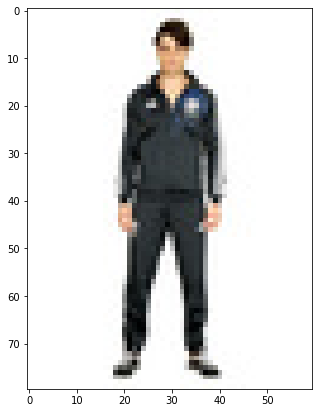

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 14:


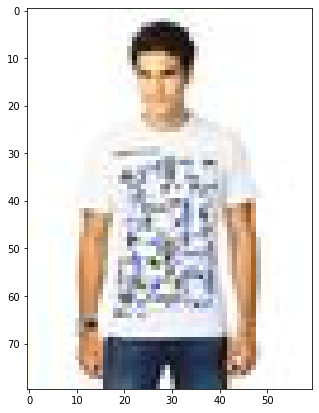

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 15:


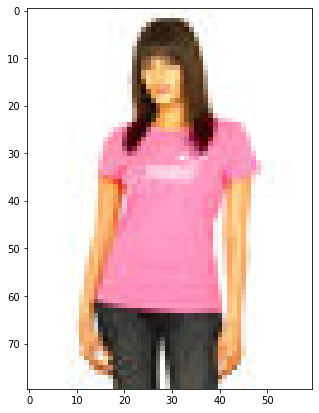

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 16:


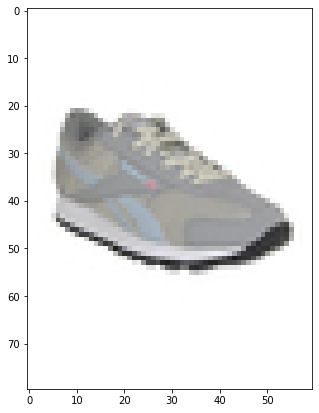

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 17:


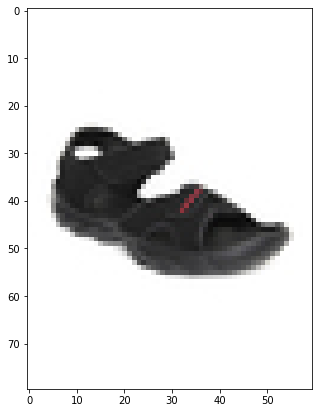

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 18:


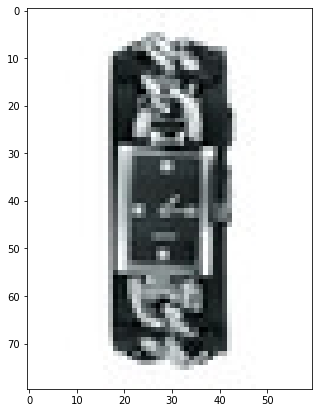

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 19:


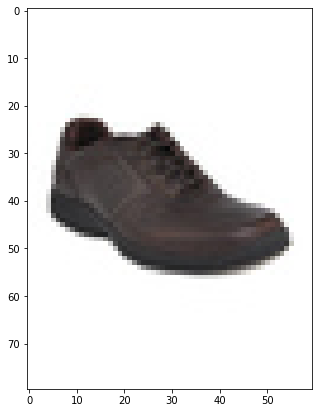

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 20:


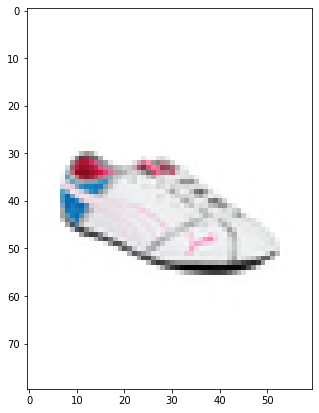

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 21:


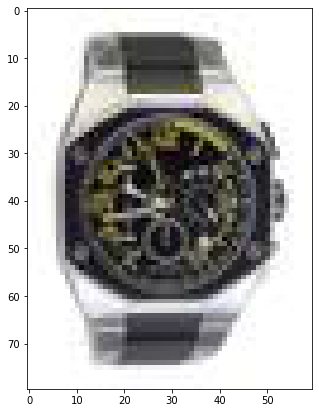

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 22:


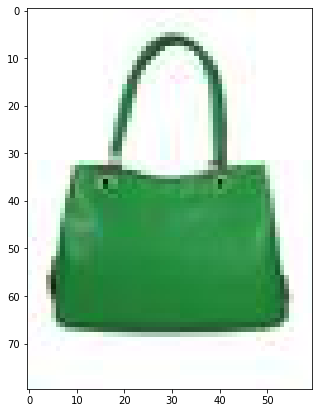

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 23:


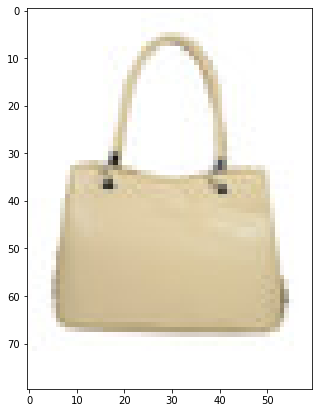

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 24:


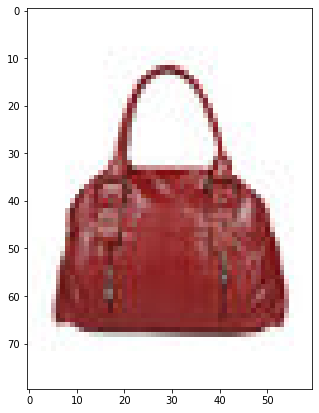

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 25:


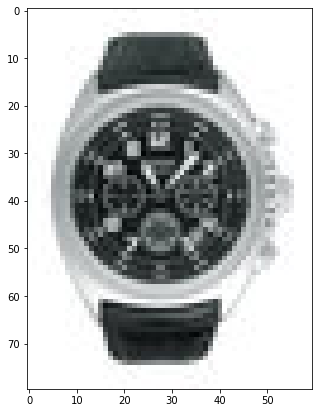

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 26:


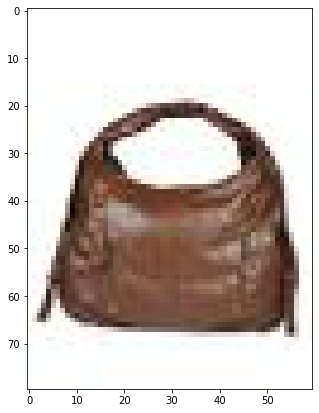

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 27:


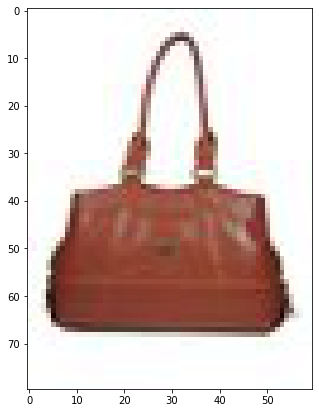

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 28:


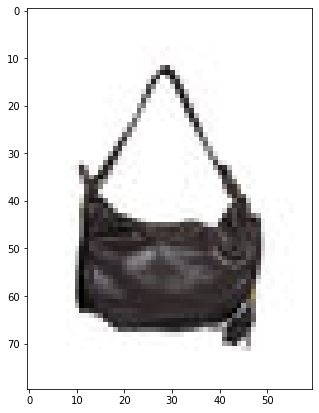

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 29:


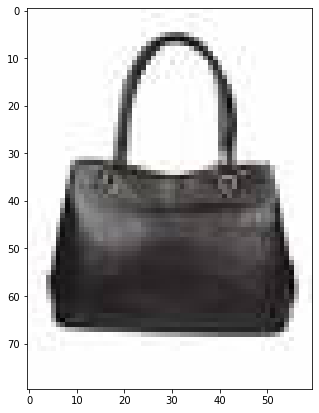

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 30:


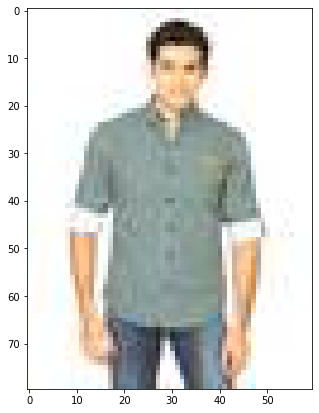

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 31:


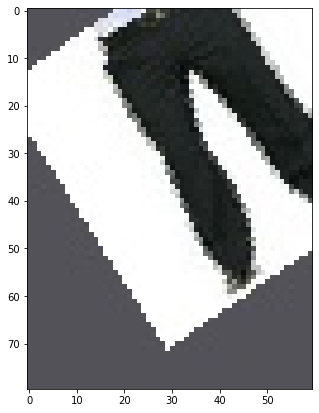

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 32:


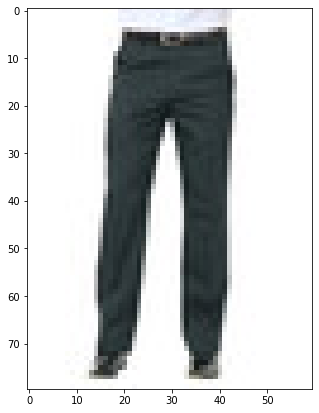

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 33:


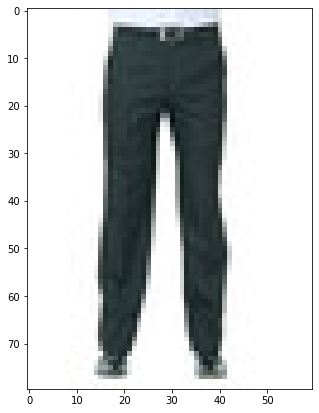

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 34:


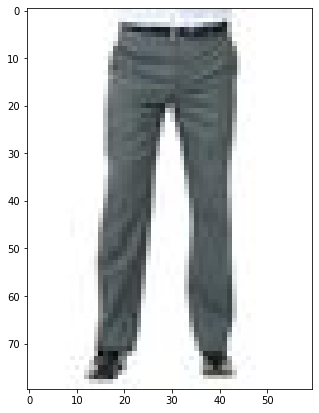

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 35:


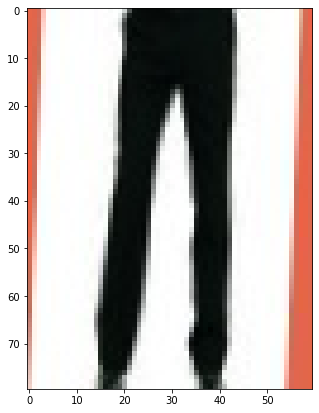

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 36:


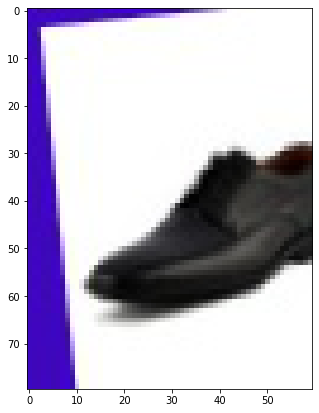

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 37:


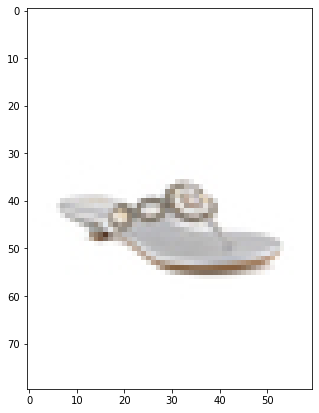

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 38:


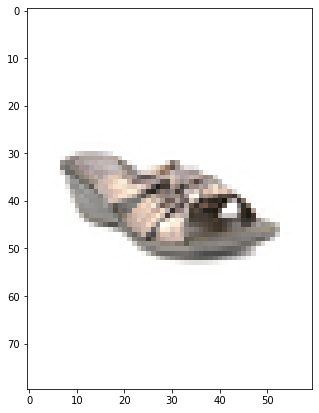

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 39:


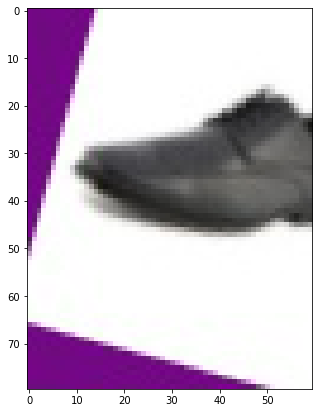

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 40:


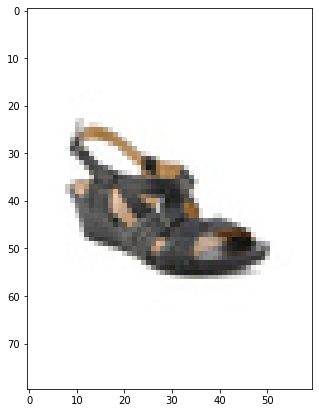

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 41:


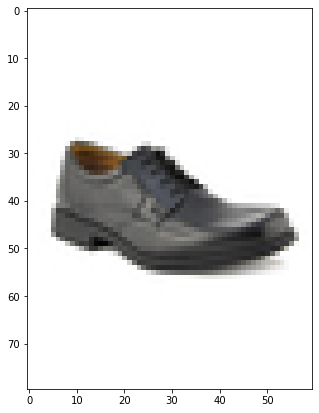

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 42:


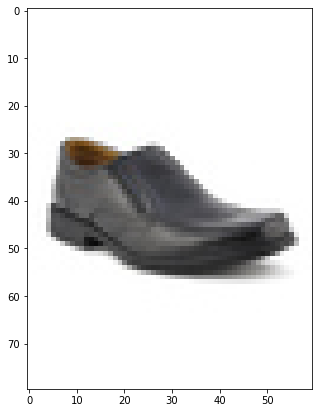

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 43:


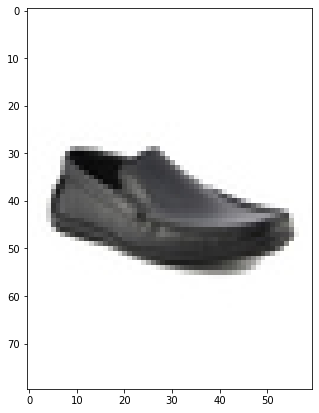

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 44:


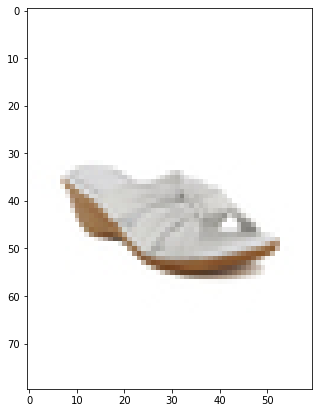

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 45:


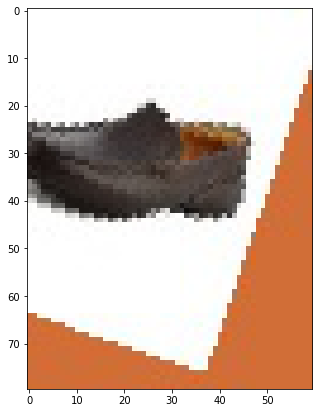

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 46:


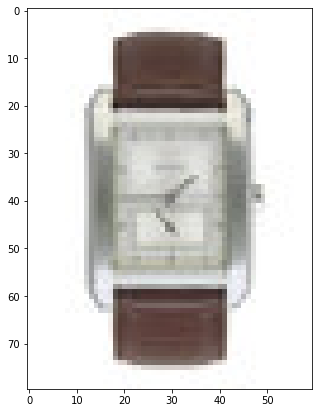

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 47:


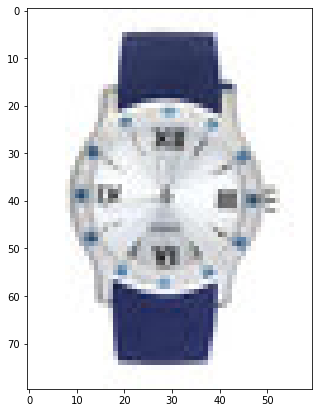

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 48:


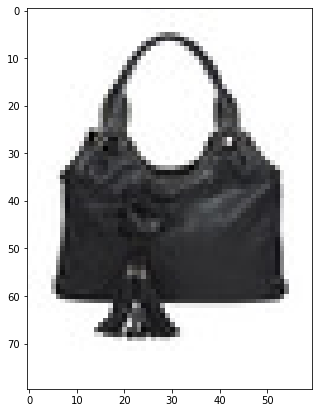

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 49:


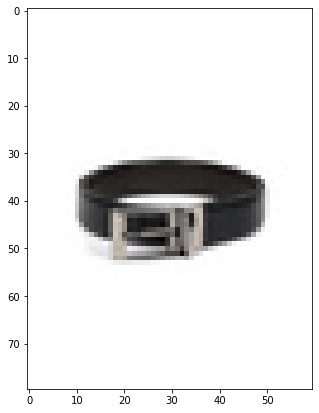

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 50:


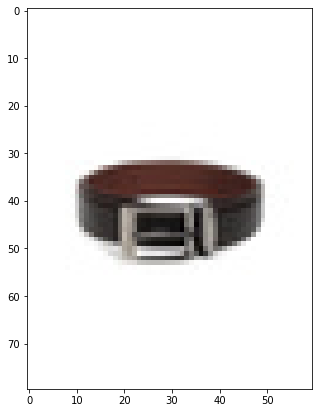

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 51:


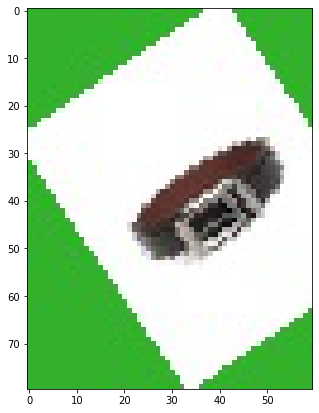

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 52:


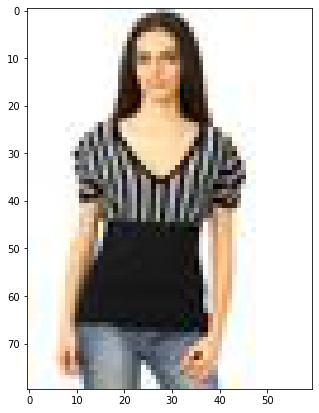

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 53:


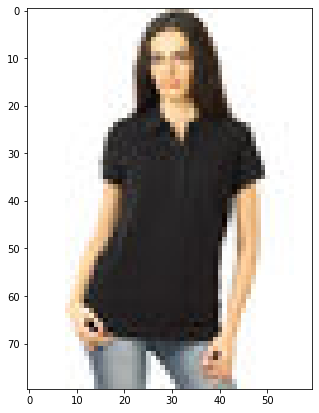

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 54:


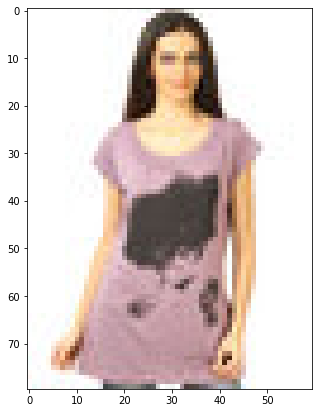

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 55:


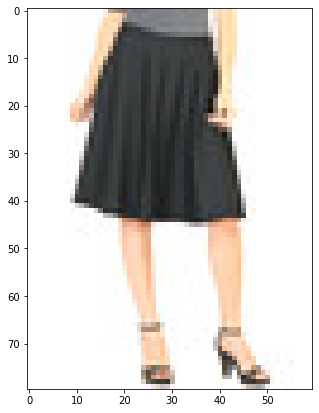

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 56:


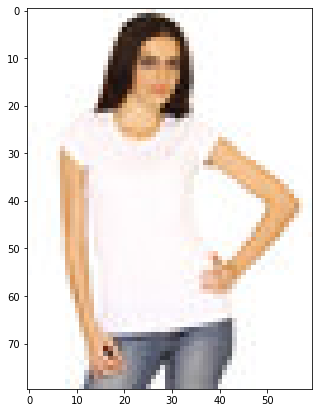

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 57:


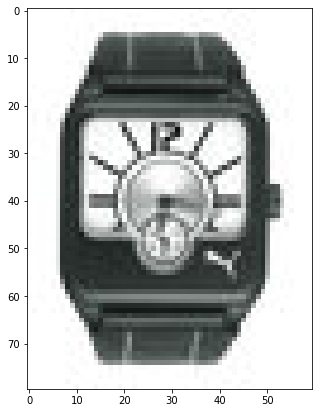

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 58:


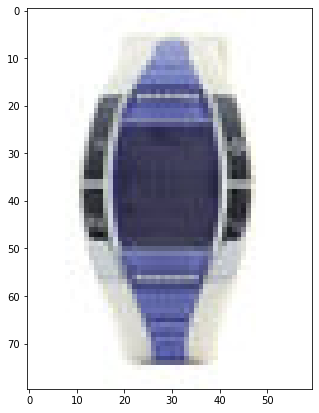

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 59:


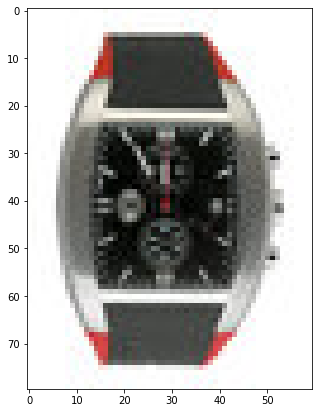

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 60:


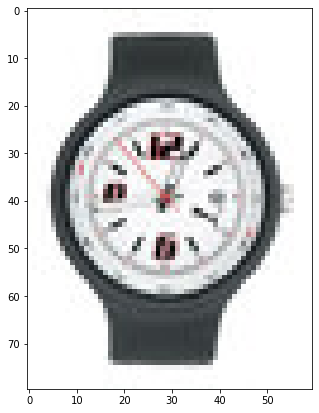

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 61:


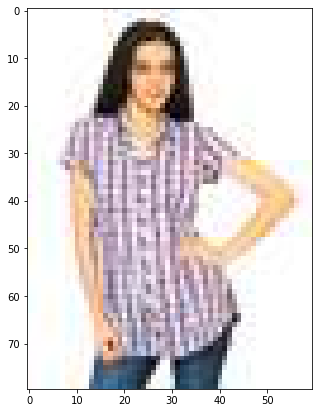

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 62:


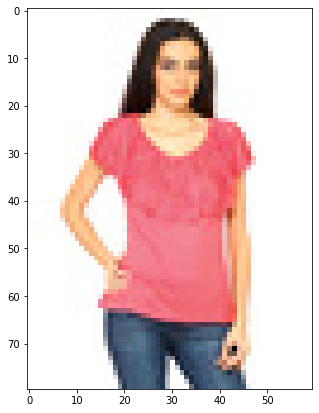

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 63:


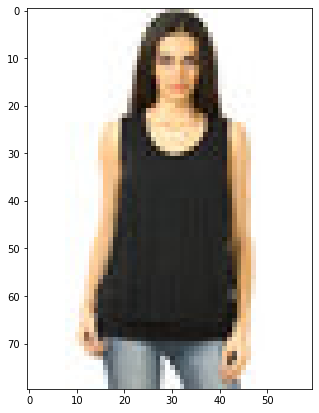

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 64:


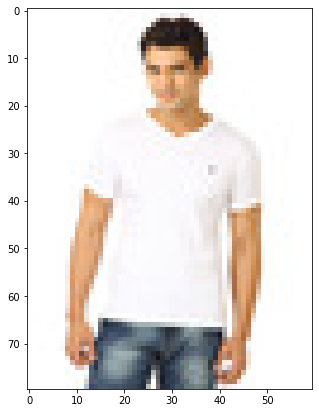

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 65:


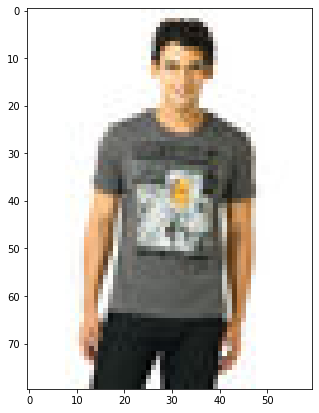

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 66:


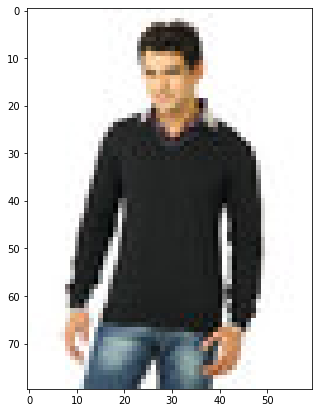

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 67:


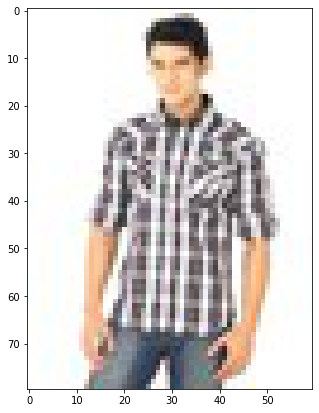

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 68:


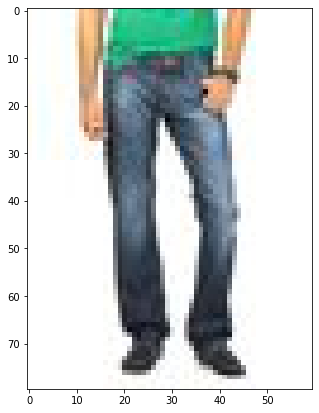

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 69:


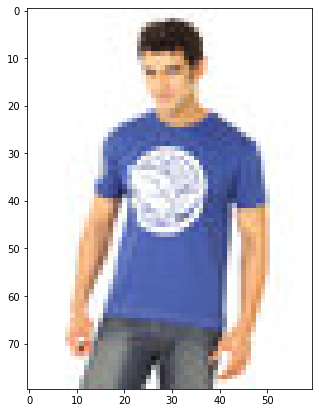

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 70:


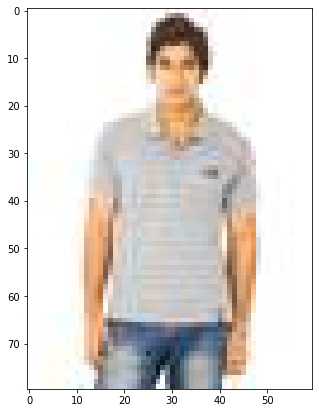

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 71:


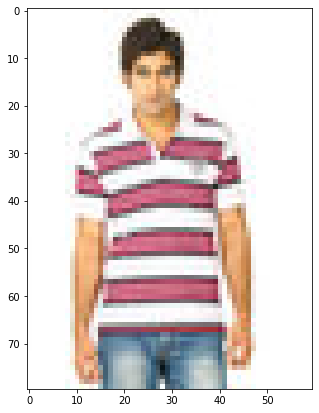

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 72:


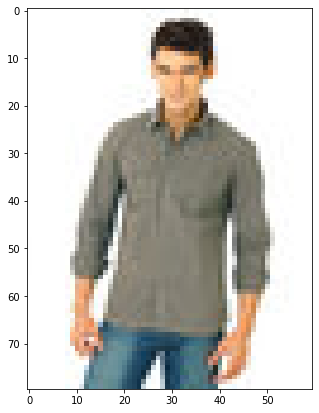

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 73:


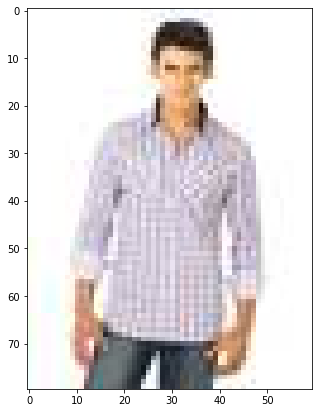

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 74:


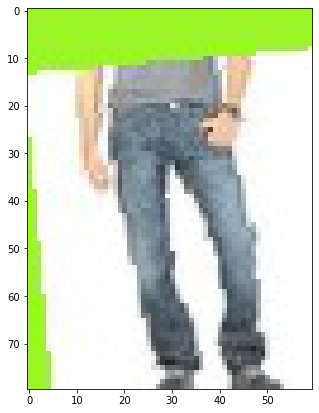

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 75:


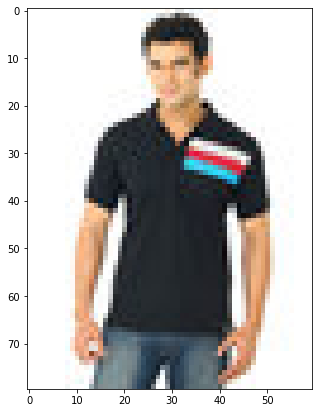

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 76:


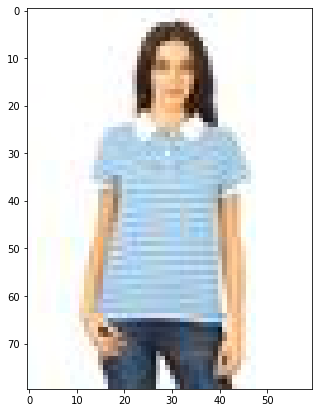

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 77:


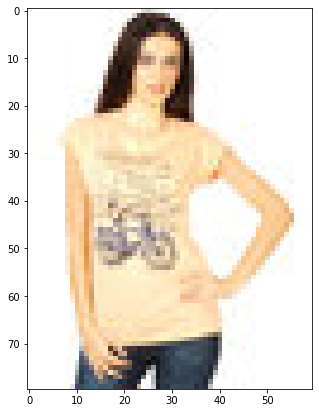

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 78:


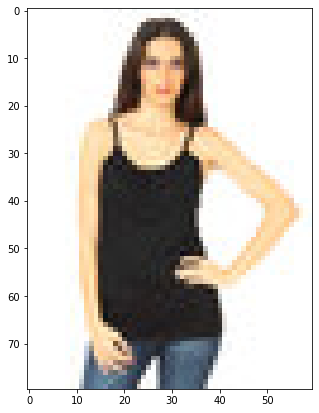

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 79:


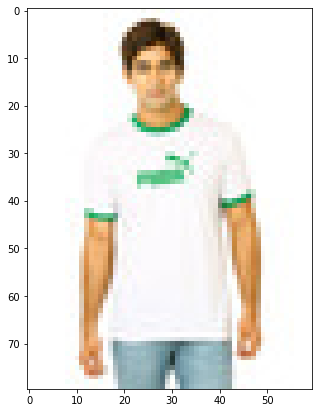

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 80:


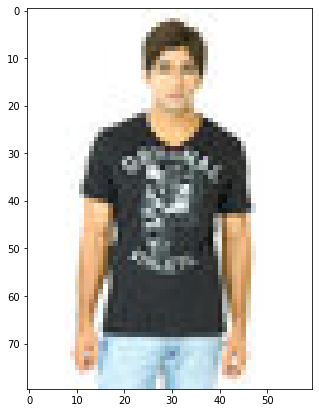

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 81:


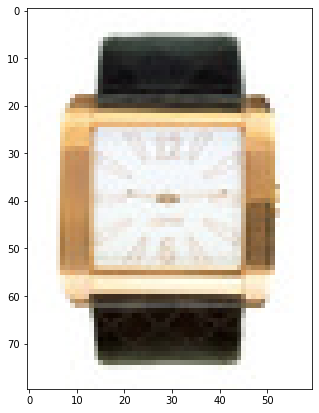

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 82:


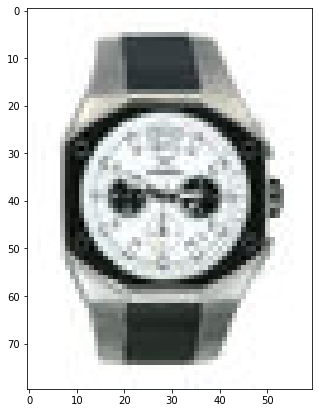

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 83:


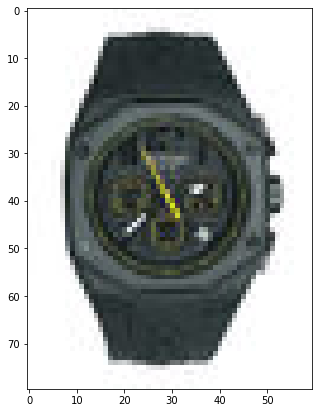

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 84:


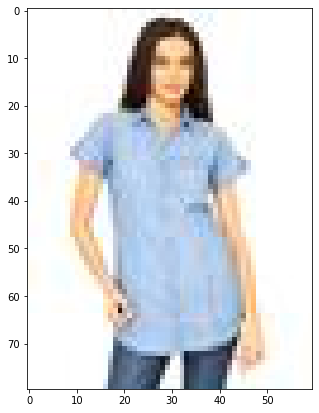

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 85:


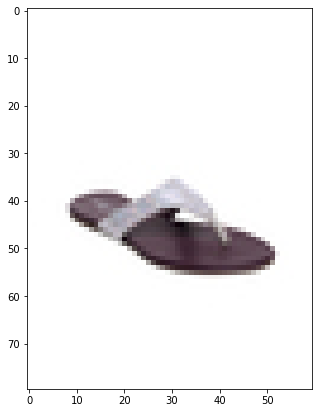

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 86:


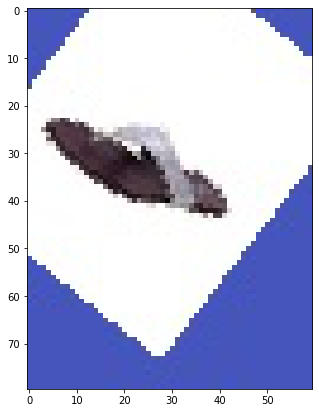

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 87:


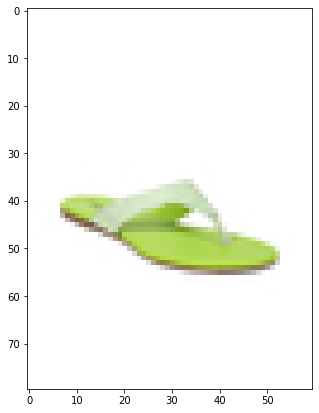

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 88:


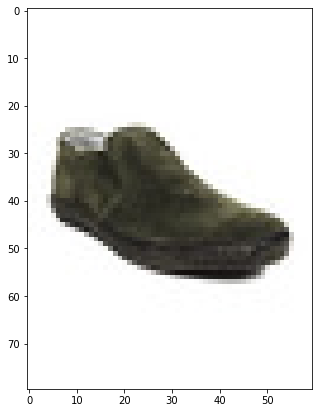

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 89:


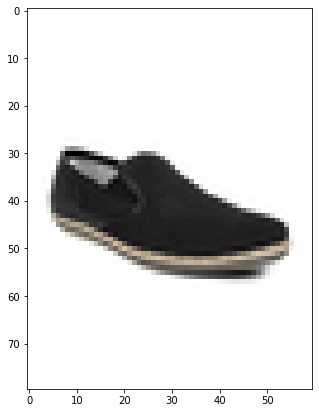

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 90:


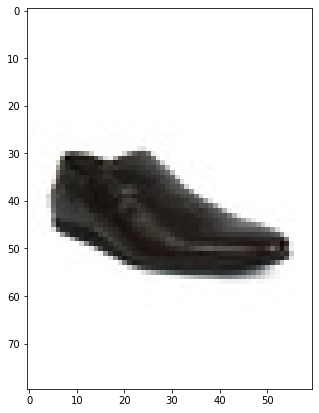

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 91:


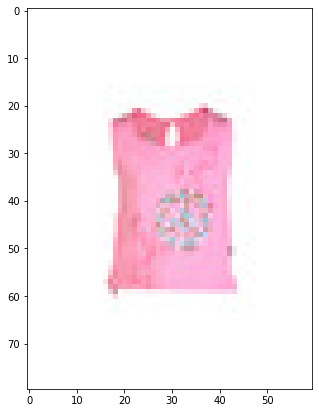

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 92:


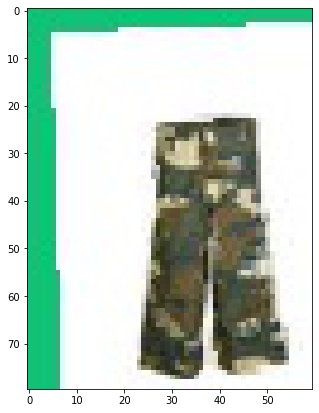

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 93:


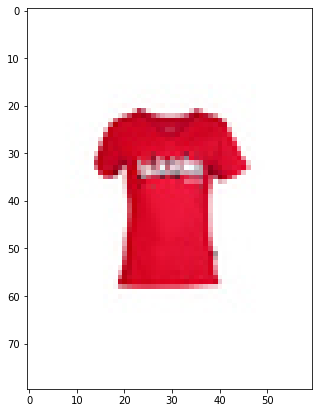

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 94:


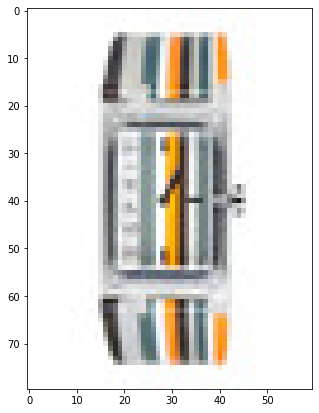

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 95:


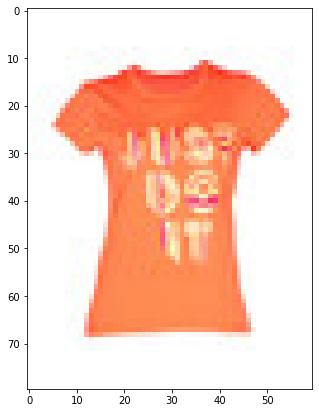

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 96:


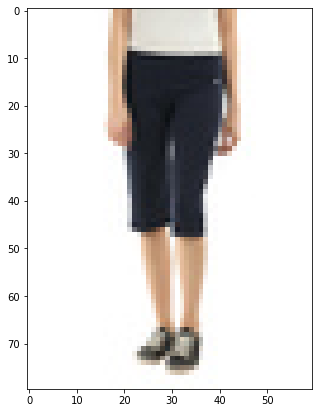

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 97:


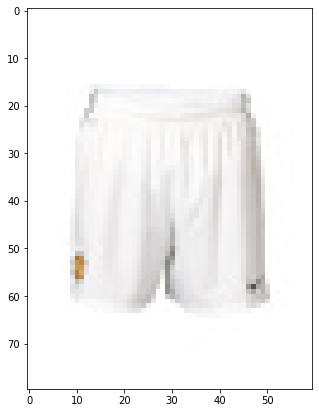

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 98:


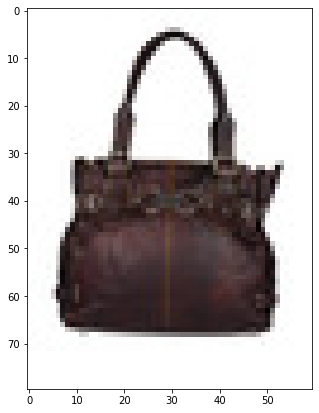

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 99:


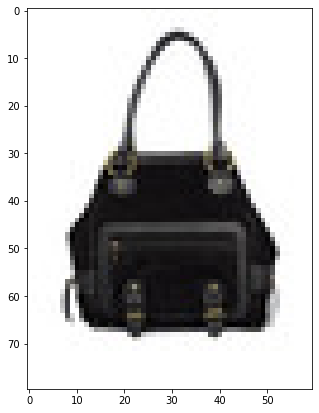

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 100:


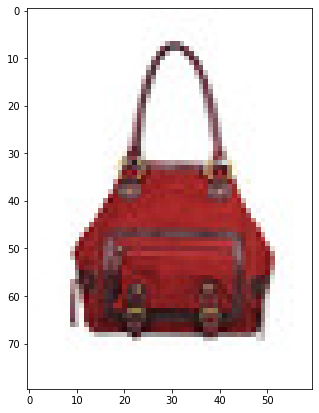

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 101:


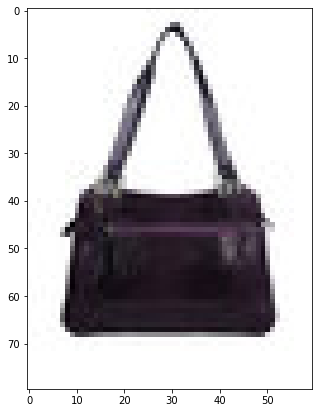

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 102:


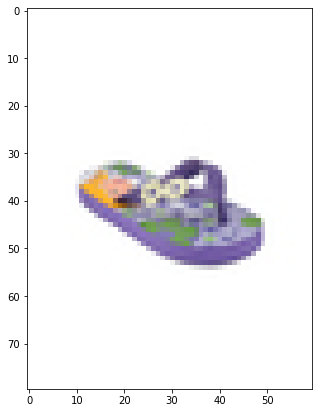

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 103:


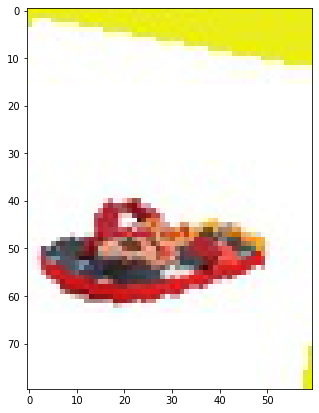

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 104:


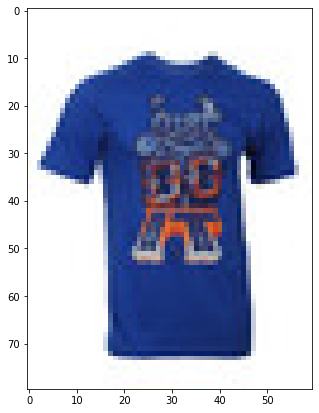

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 105:


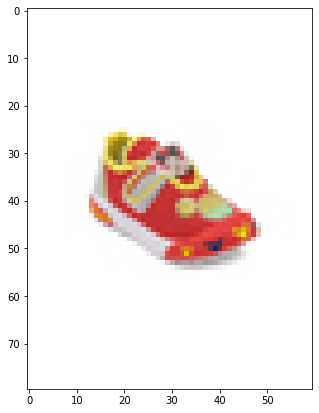

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 106:


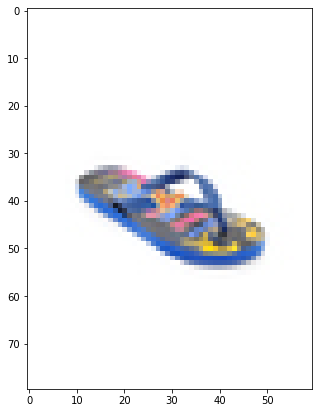

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 107:


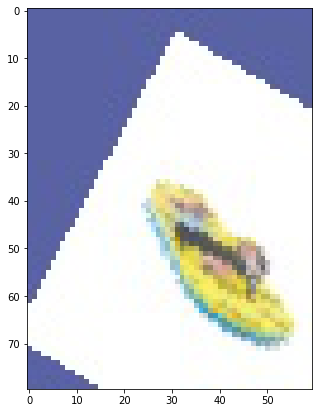

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 108:


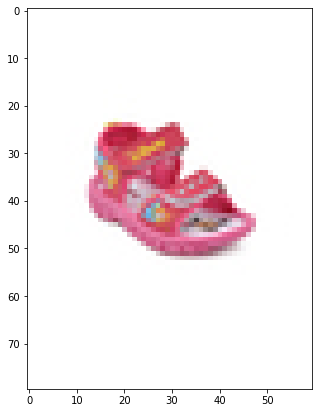

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 109:


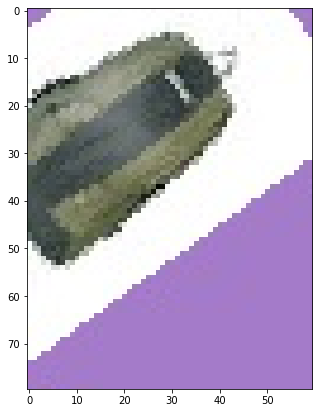

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 110:


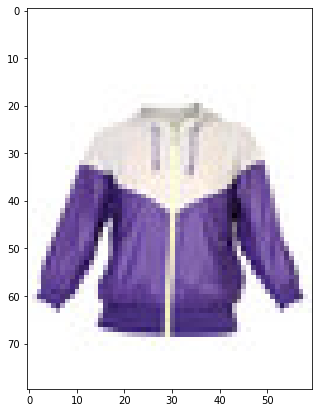

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 111:


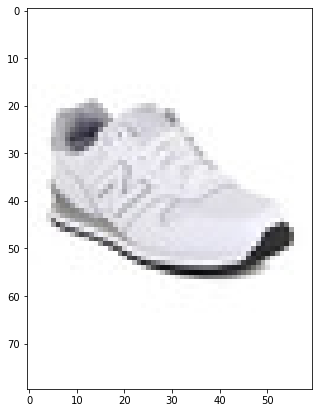

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 112:


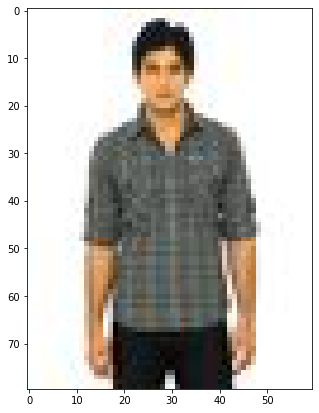

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 113:


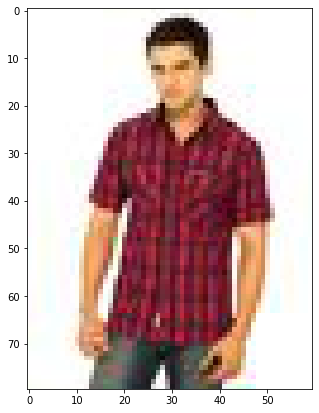

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 114:


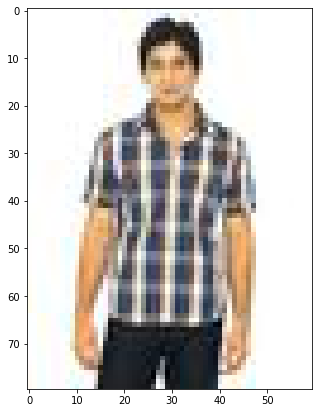

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 115:


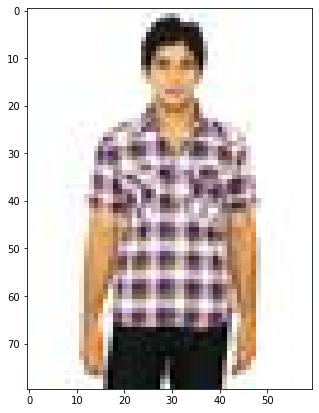

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 116:


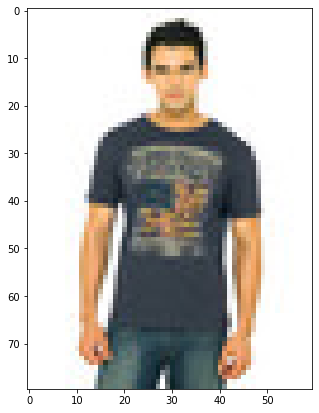

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 117:


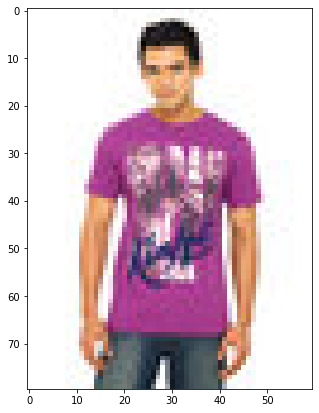

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 118:


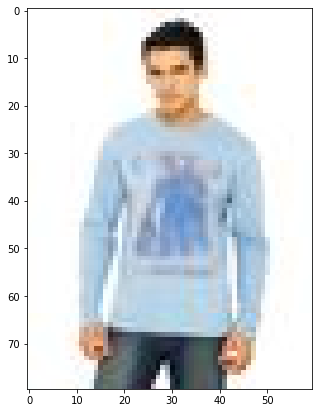

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 119:


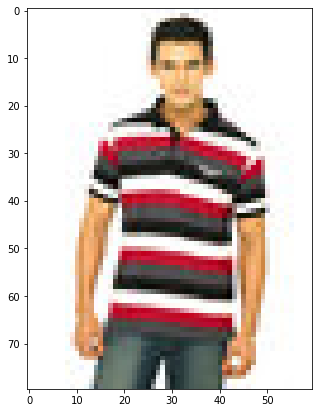

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 120:


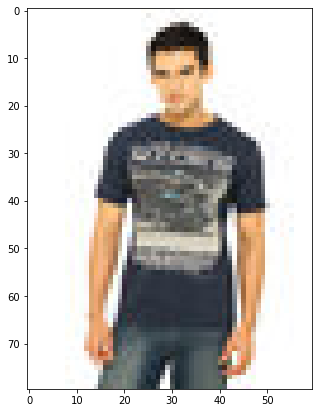

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 121:


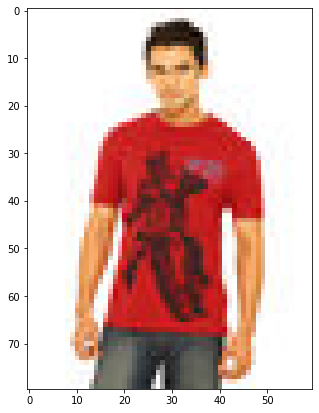

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 122:


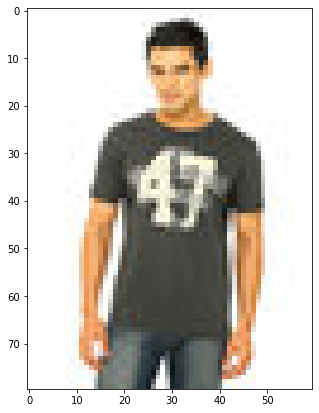

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 123:


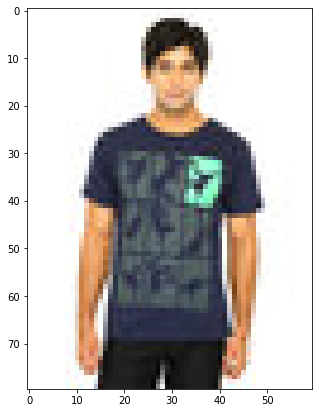

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 124:


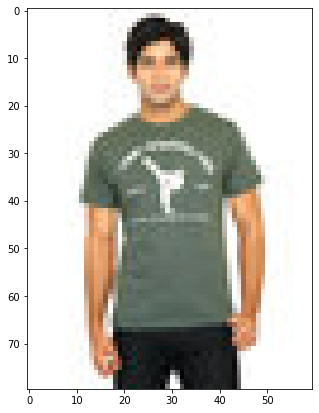

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 125:


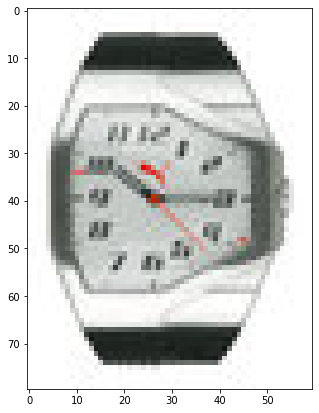

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 126:


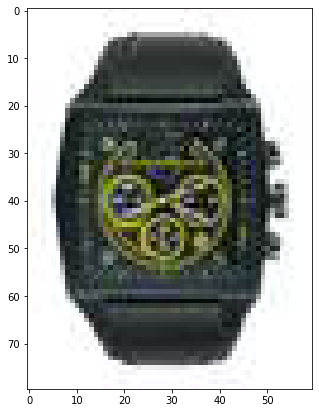

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 127:


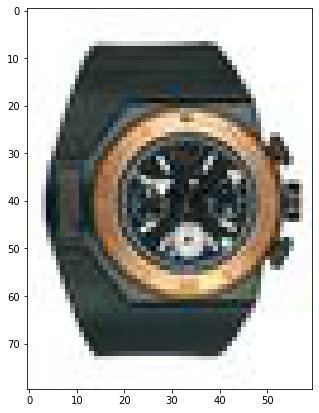

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 128:


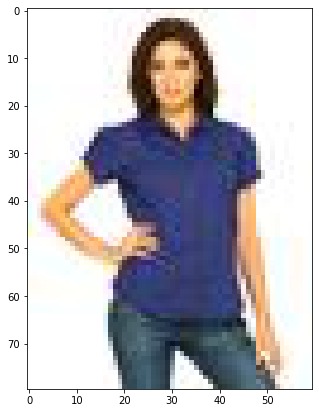

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 129:


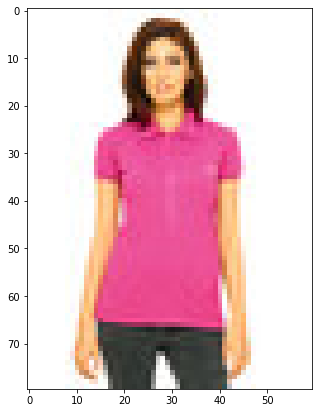

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 130:


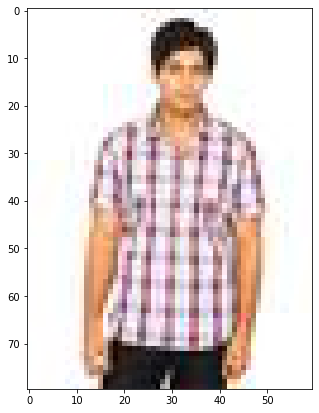

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 131:


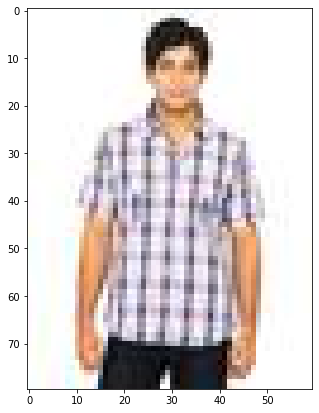

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 132:


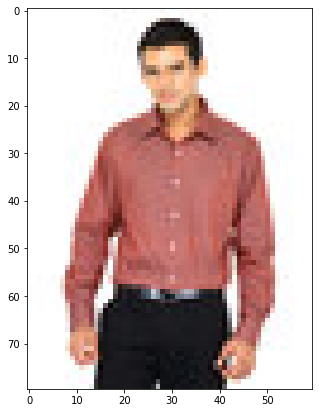

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 133:


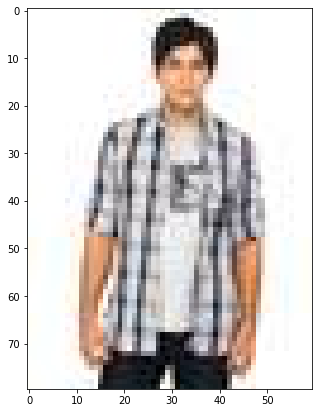

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 134:


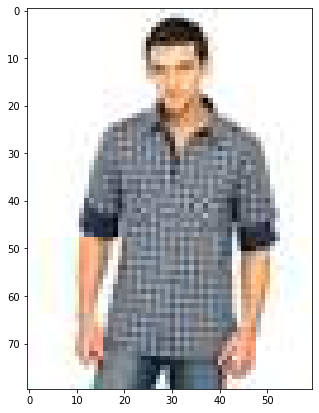

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 135:


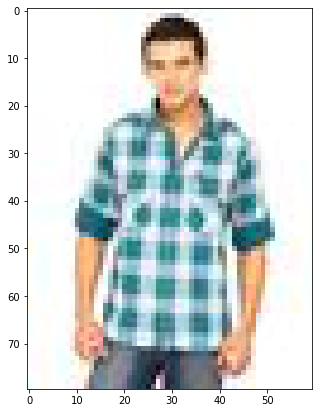

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 136:


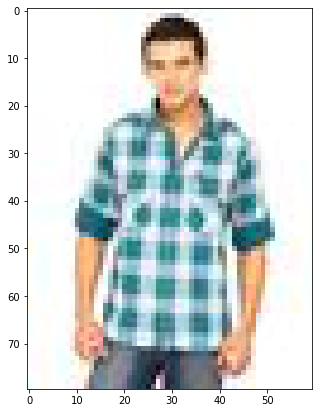

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 137:


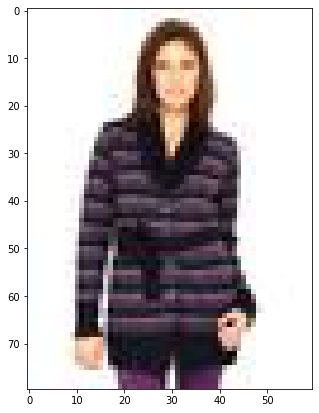

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 138:


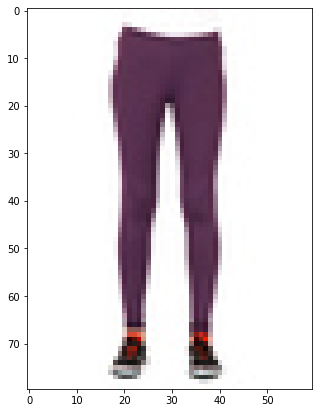

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 139:


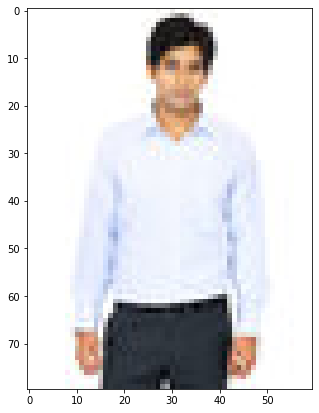

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 140:


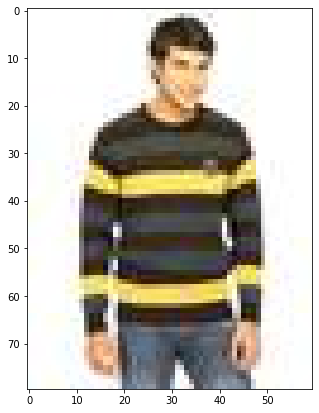

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 141:


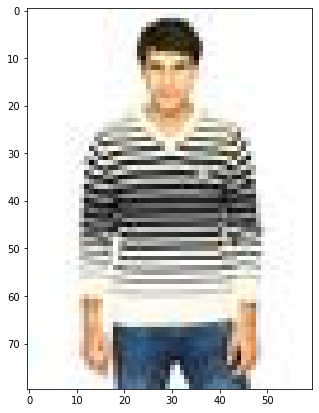

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 142:


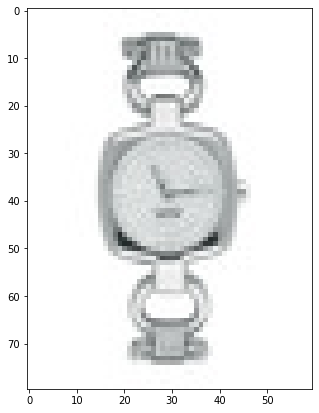

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 143:


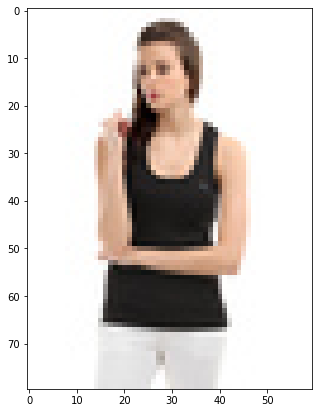

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 144:


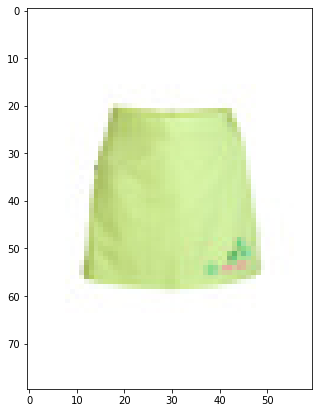

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 145:


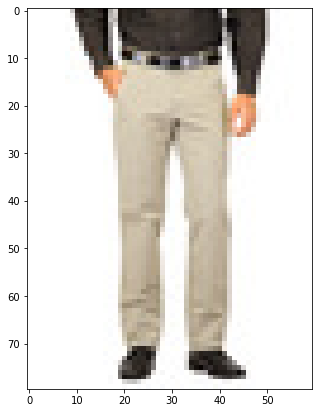

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 146:


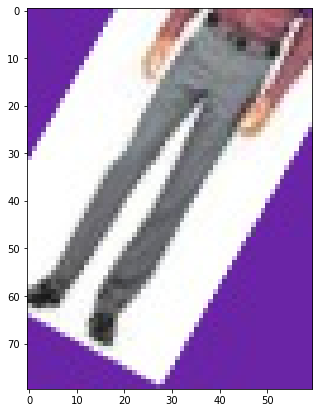

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 147:


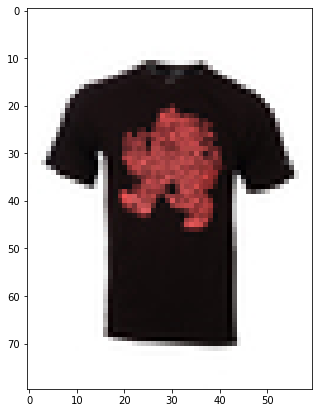

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 148:


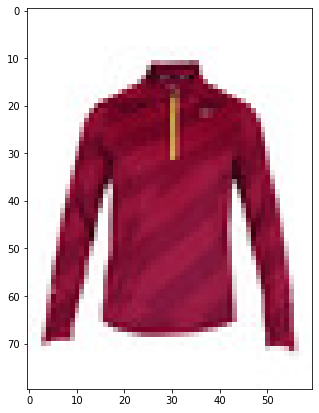

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 149:


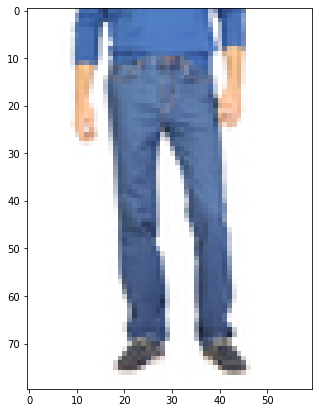

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 150:


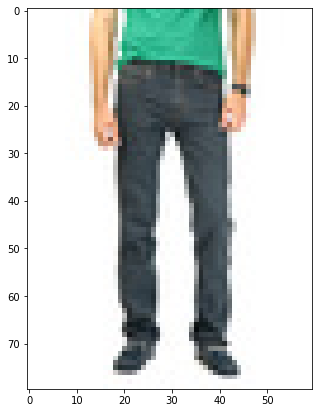

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 151:


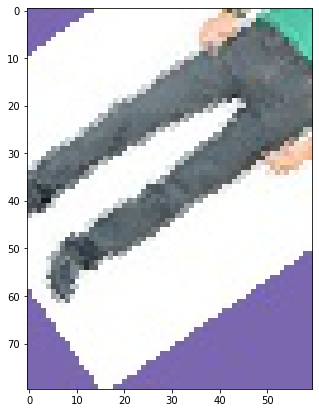

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 152:


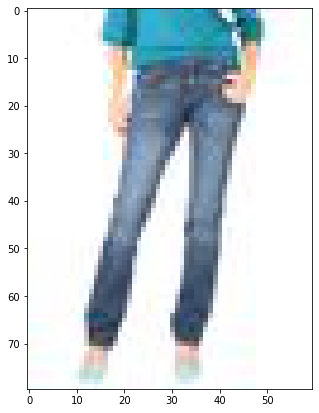

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 153:


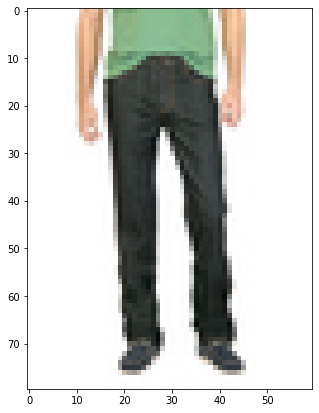

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 154:


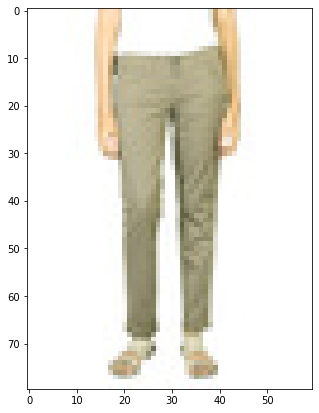

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 155:


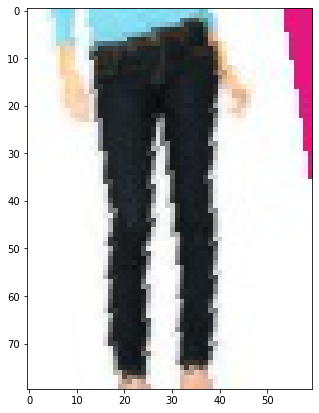

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 156:


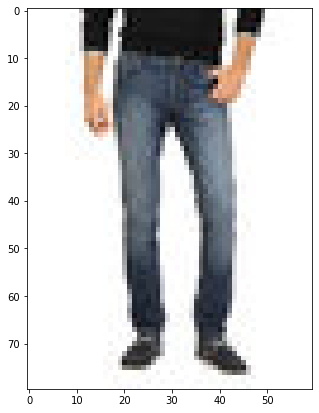

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 157:


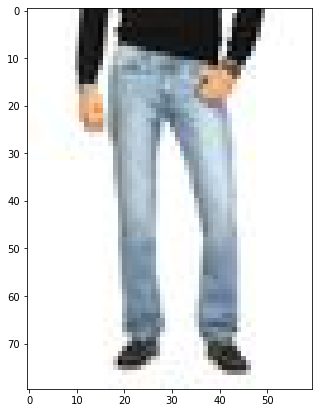

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 158:


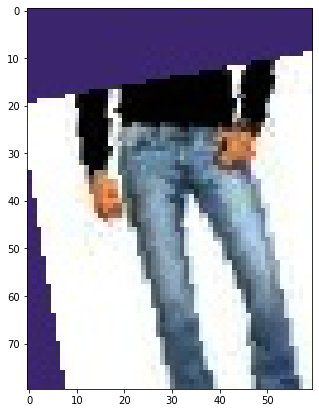

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 159:


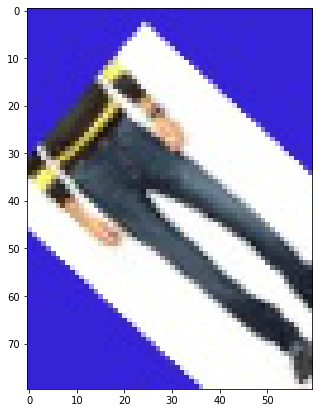

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 160:


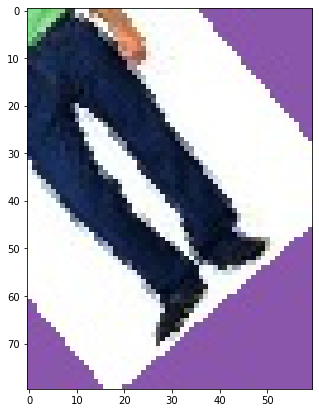

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 161:


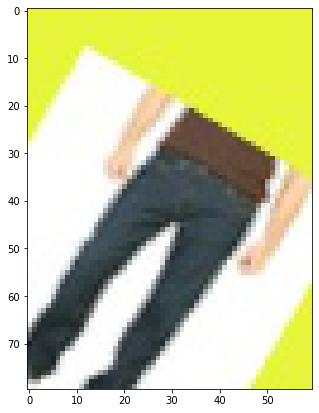

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 162:


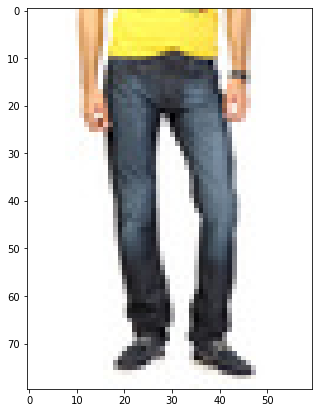

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 163:


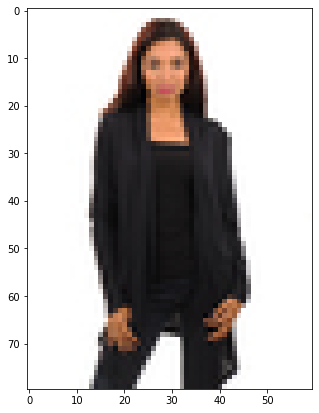

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 164:


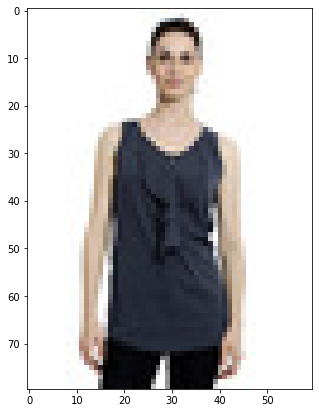

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 165:


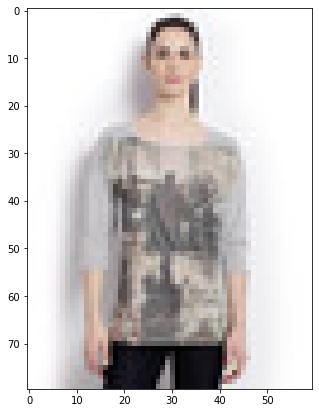

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 166:


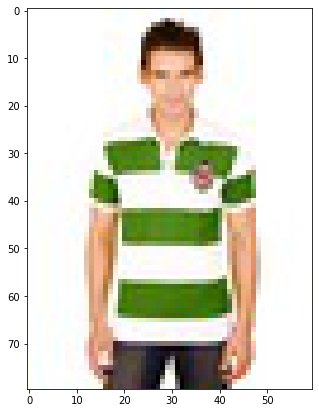

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 167:


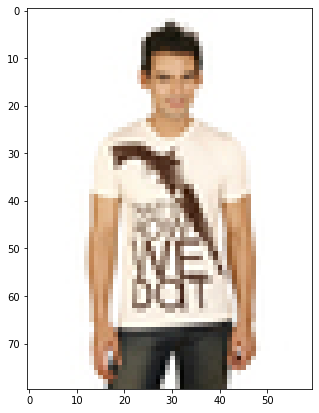

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 168:


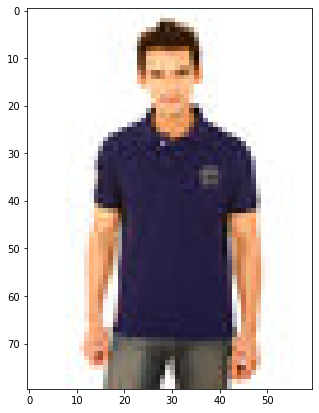

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 169:


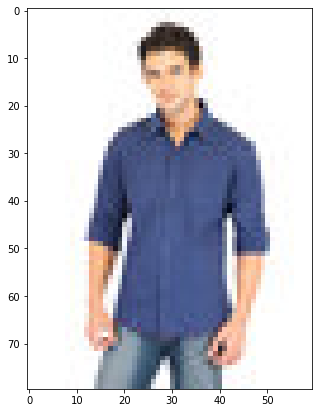

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 170:


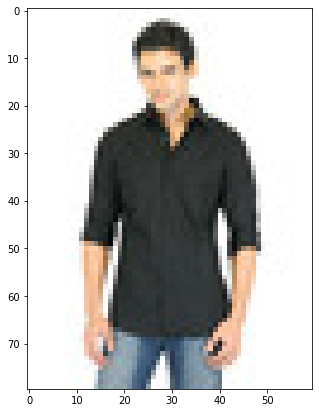

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 171:


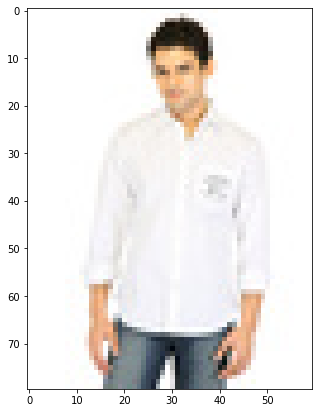

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 172:


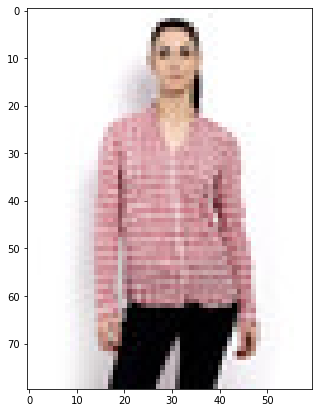

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 173:


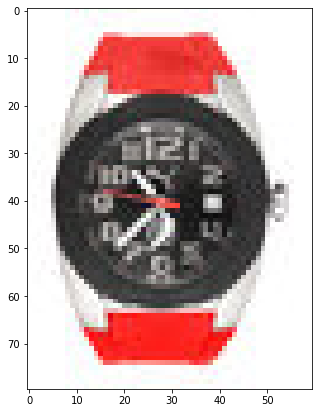

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 174:


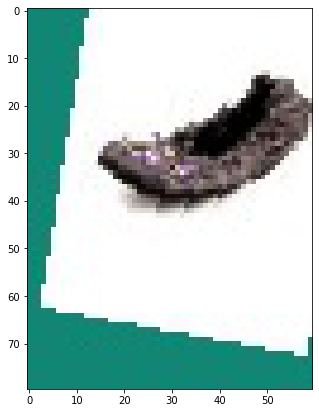

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 175:


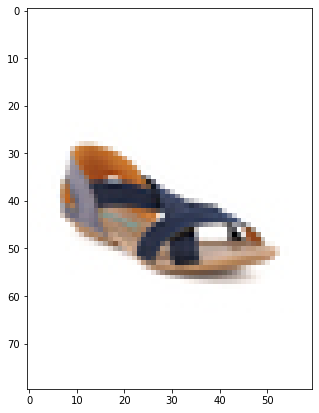

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 176:


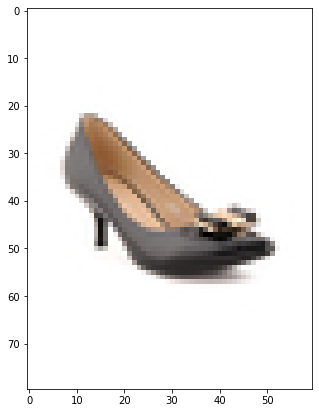

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 177:


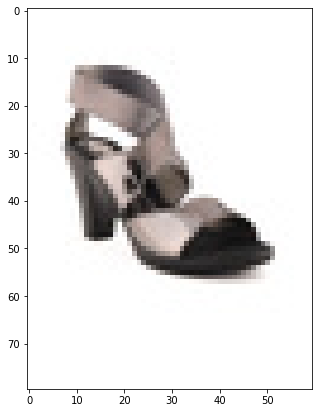

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 178:


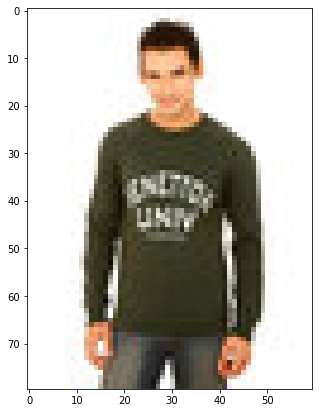

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 179:


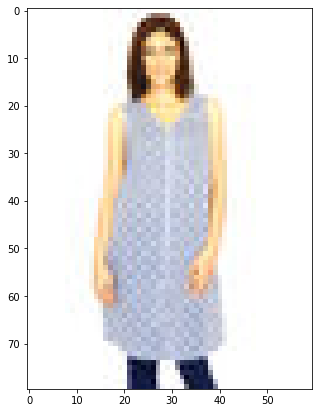

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 180:


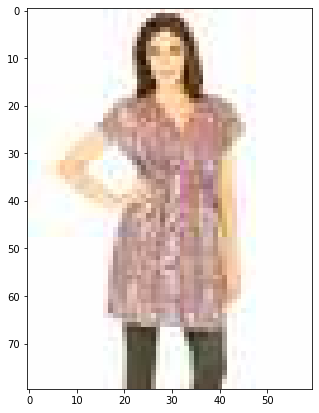

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 181:


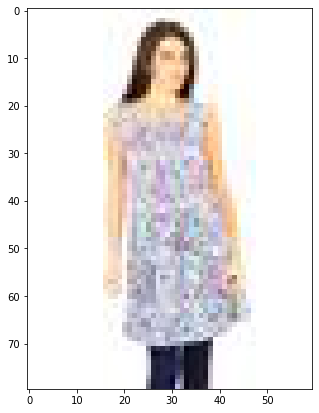

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 182:


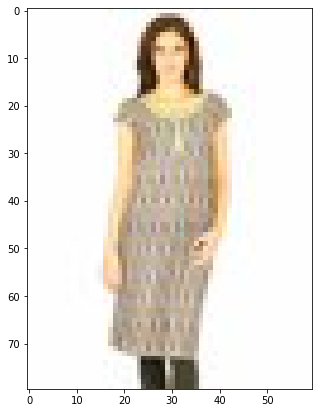

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 183:


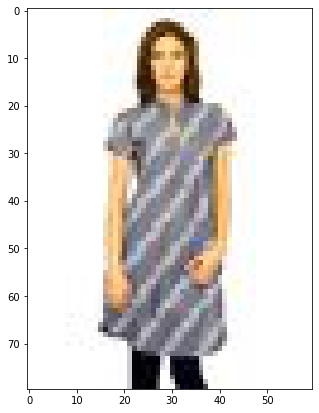

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 184:


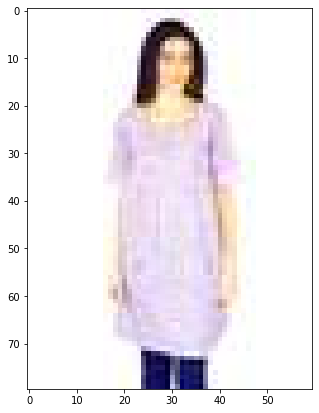

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 185:


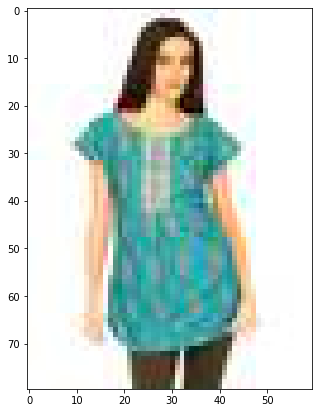

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 186:


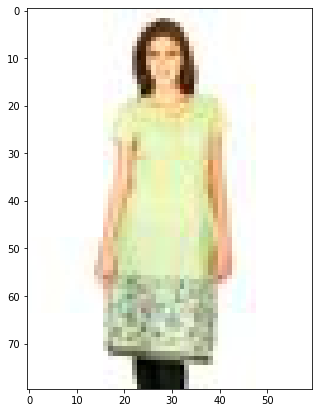

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 187:


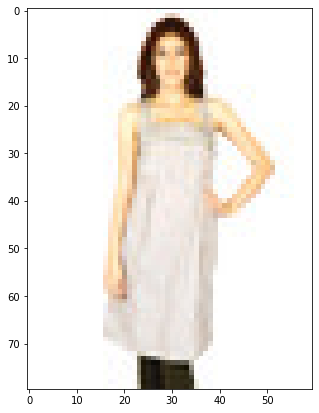

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 188:


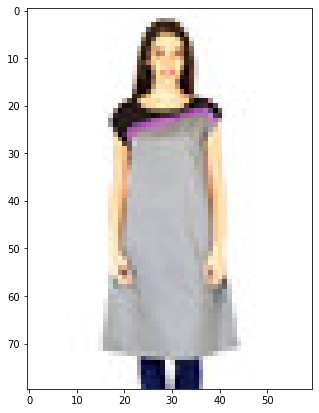

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 189:


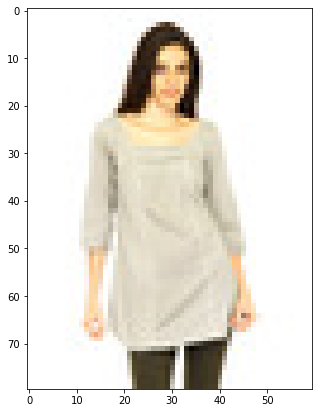

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 190:


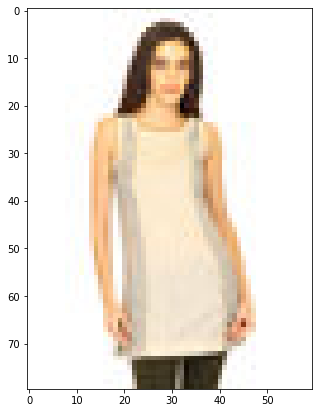

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 191:


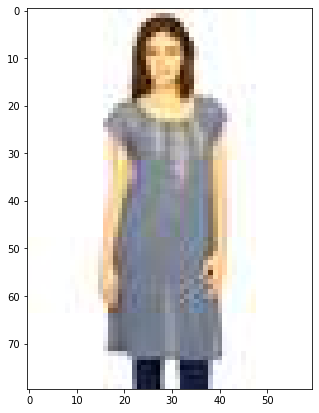

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 192:


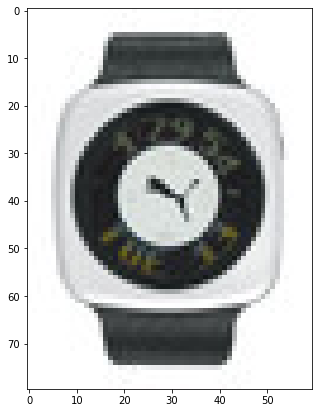

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 193:


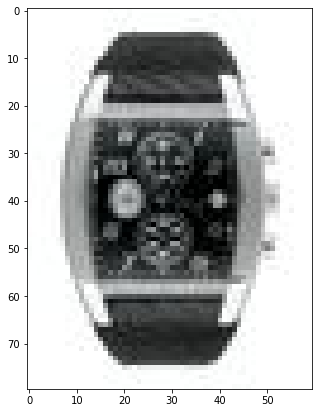

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 194:


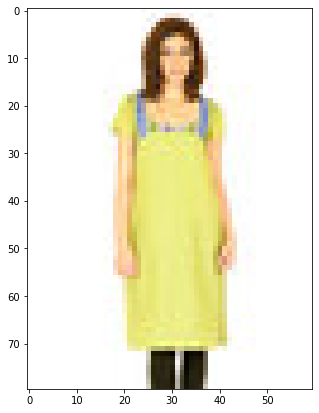

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 195:


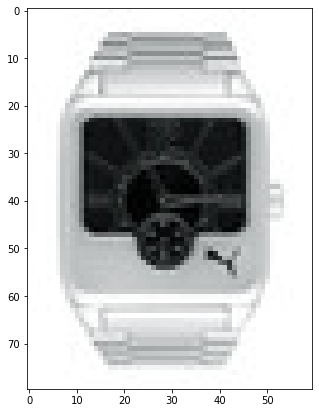

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 196:


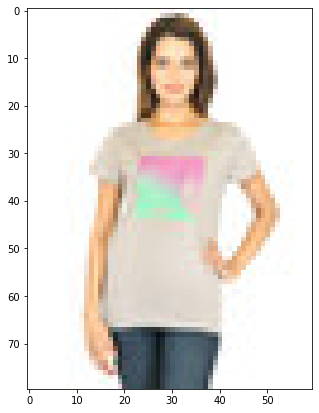

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 197:


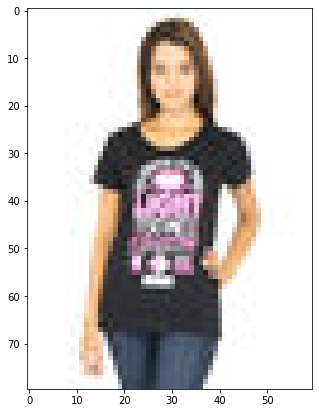

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 198:


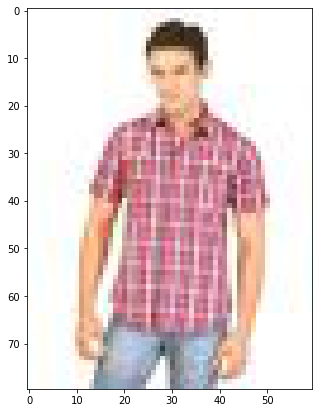

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 199:


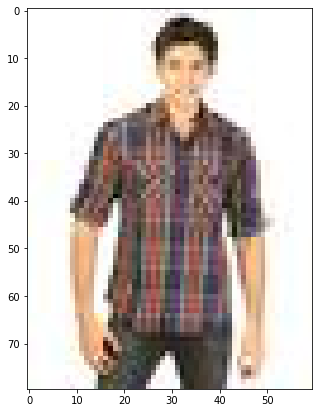

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 200:


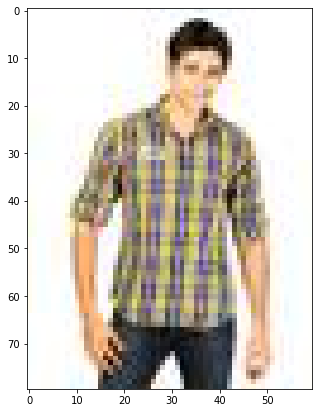

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 201:


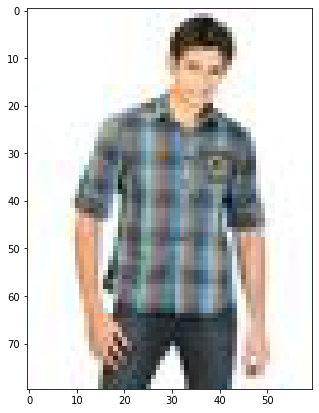

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 202:


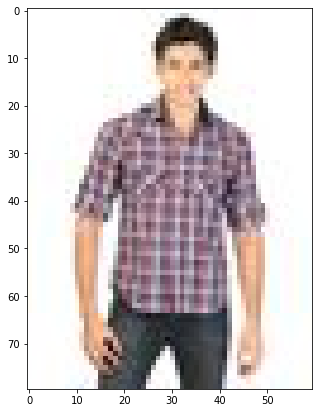

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 203:


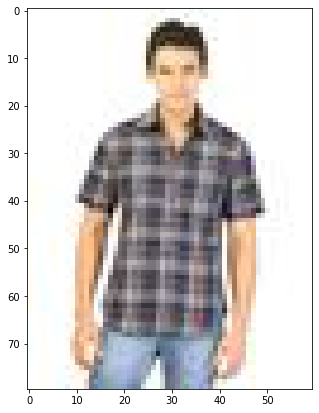

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 204:


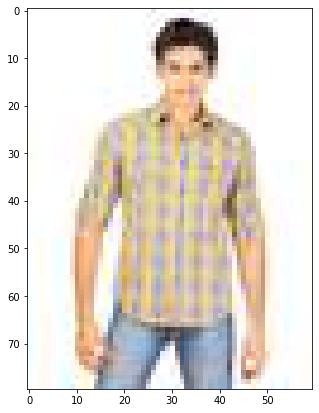

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 205:


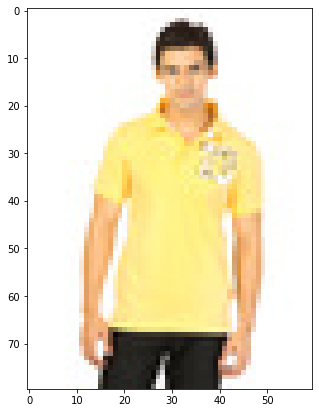

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 206:


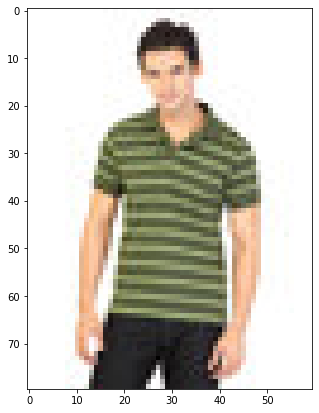

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 207:


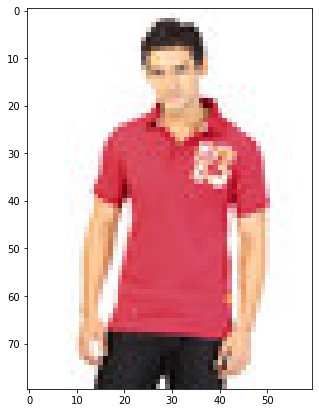

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 208:


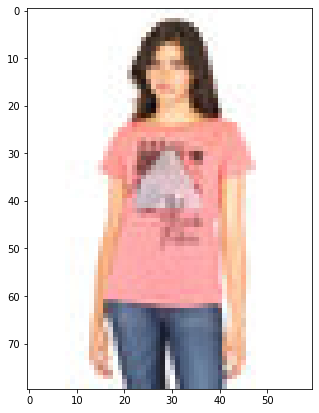

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 209:


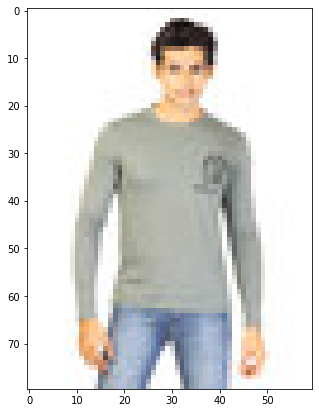

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 210:


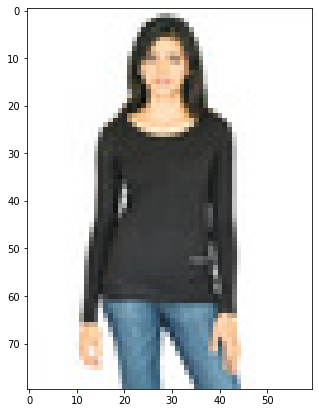

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 211:


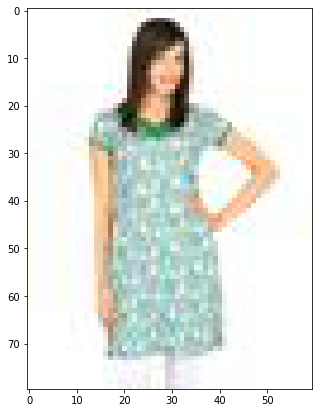

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 212:


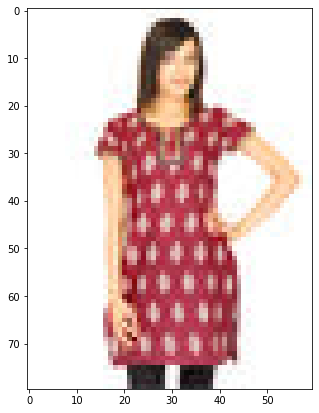

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 213:


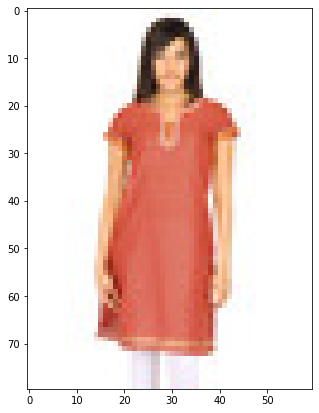

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 214:


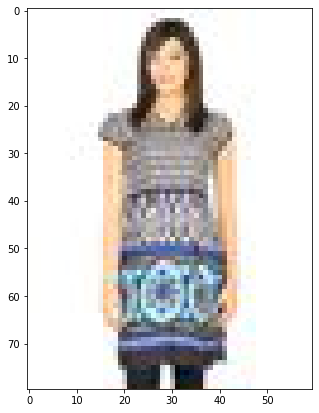

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 215:


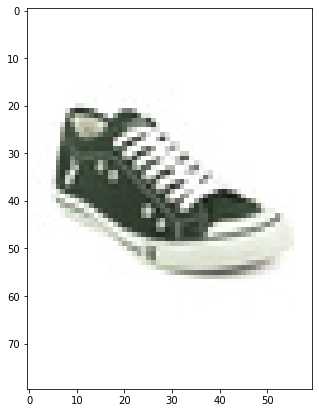

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 216:


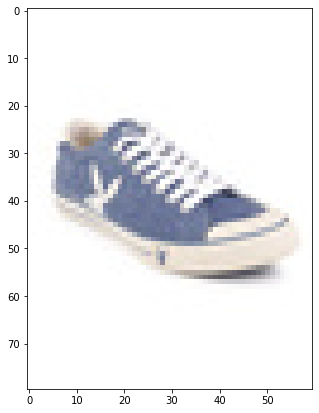

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 217:


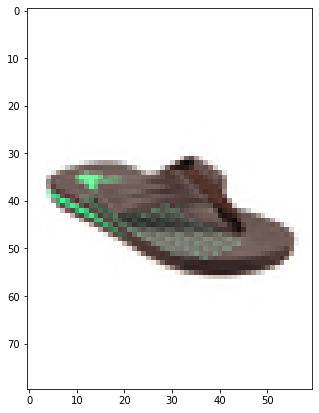

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 218:


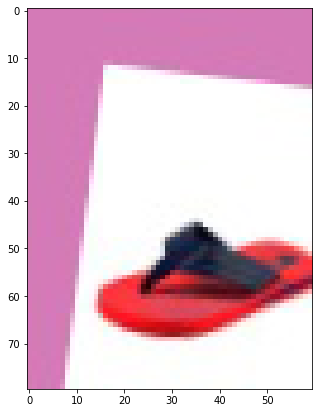

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 219:


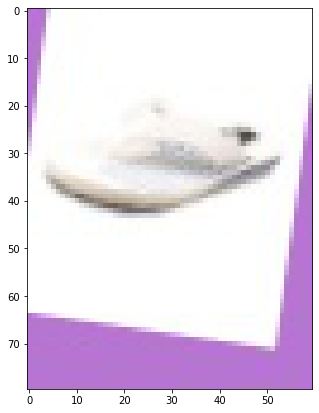

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 220:


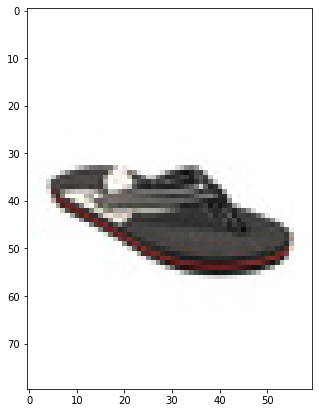

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 221:


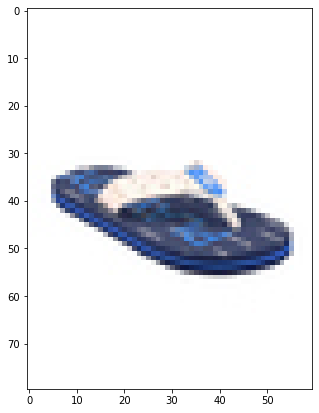

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 222:


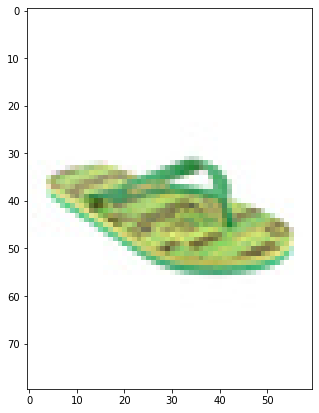

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 223:


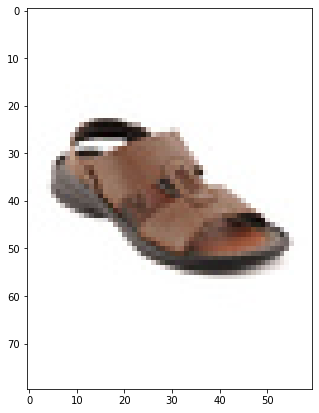

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 224:


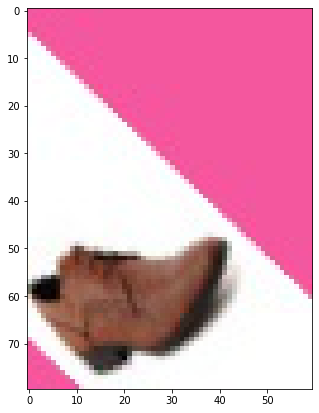

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 225:


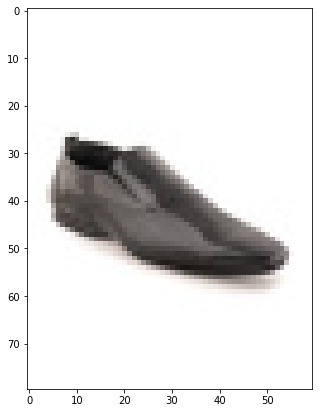

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 226:


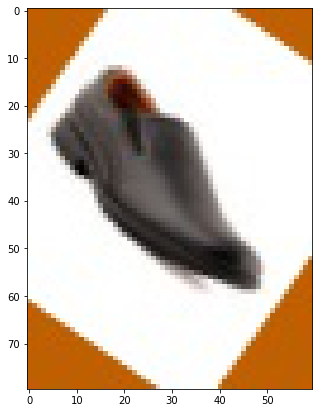

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 227:


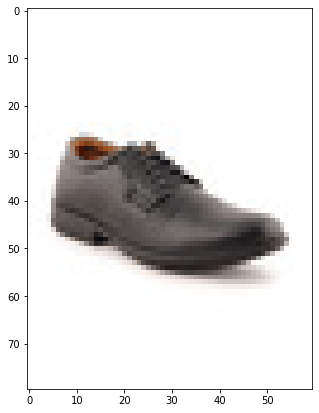

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 228:


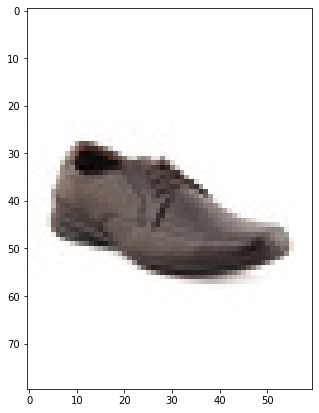

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 229:


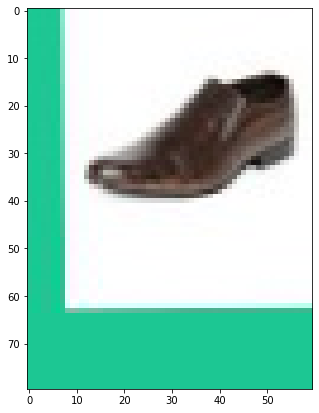

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 230:


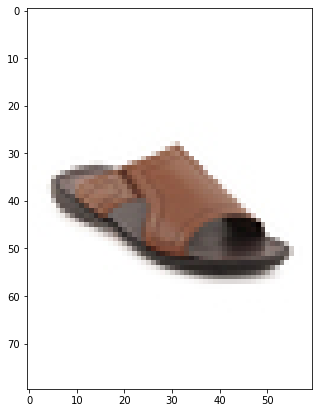

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 231:


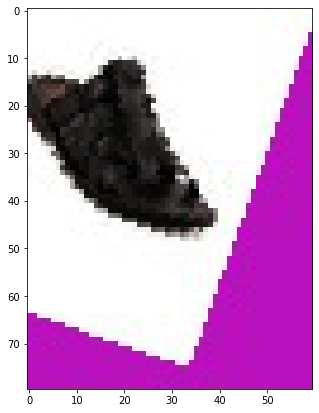

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 232:


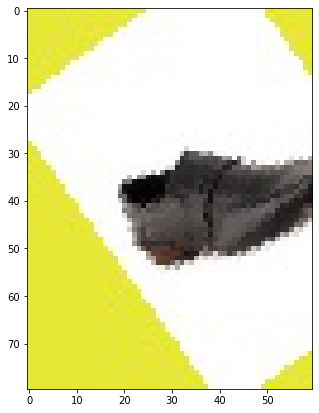

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 233:


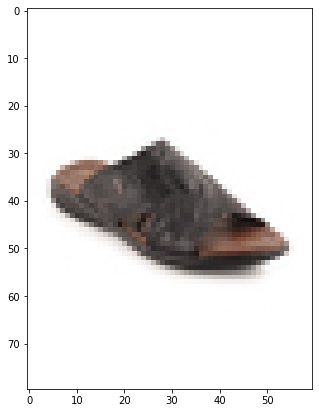

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 234:


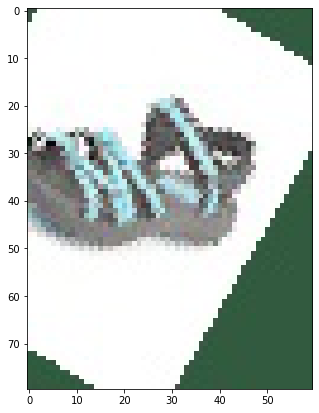

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 235:


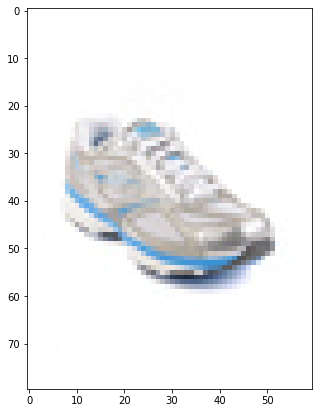

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 236:


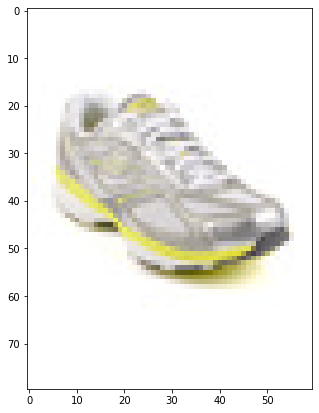

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 237:


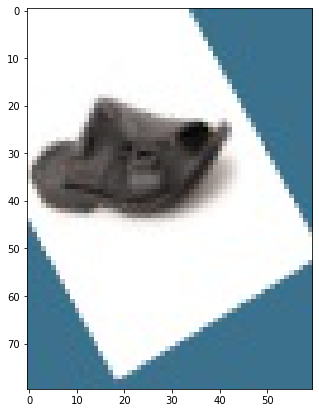

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 238:


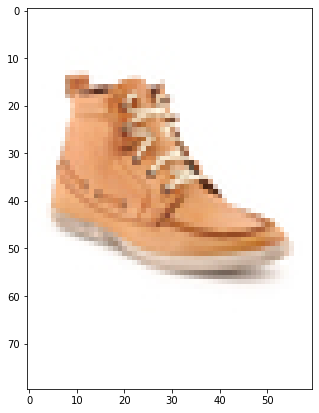

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 239:


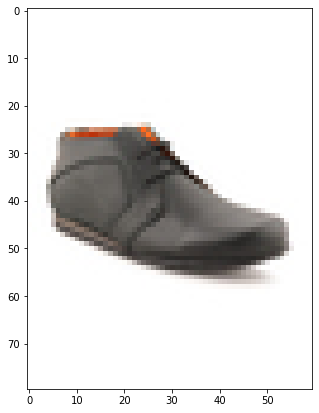

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 240:


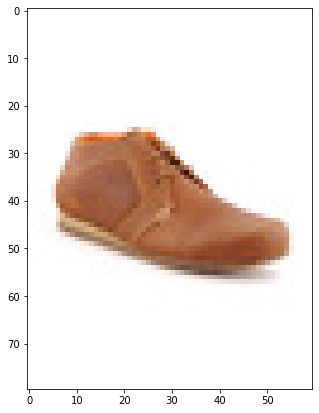

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 241:


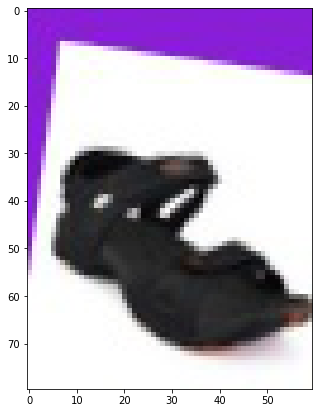

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 242:


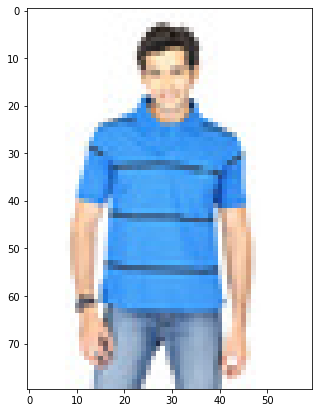

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 243:


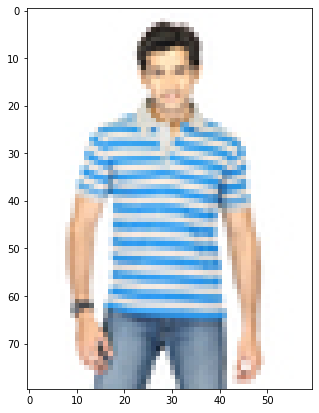

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 244:


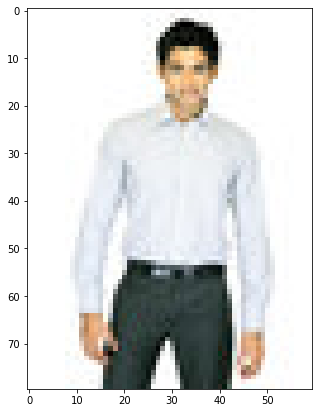

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 245:


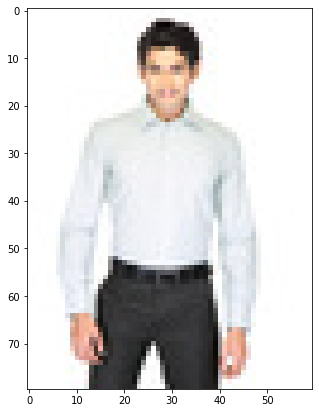

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 246:


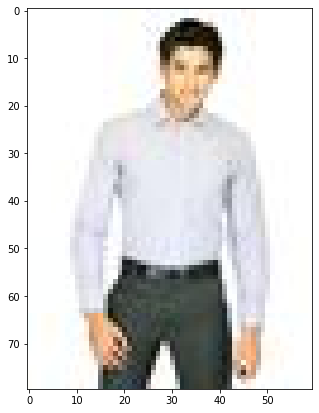

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 247:


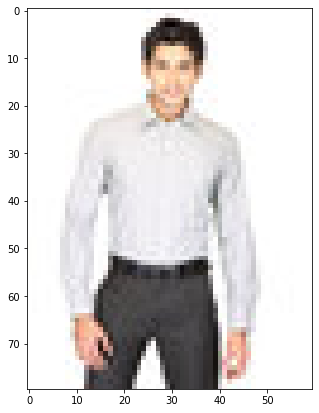

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 248:


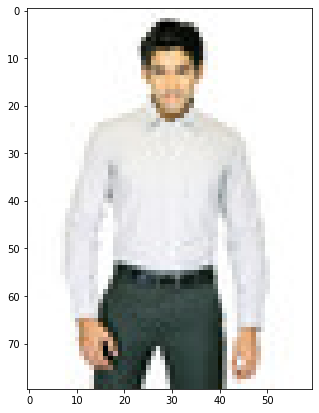

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)


Input image 249:


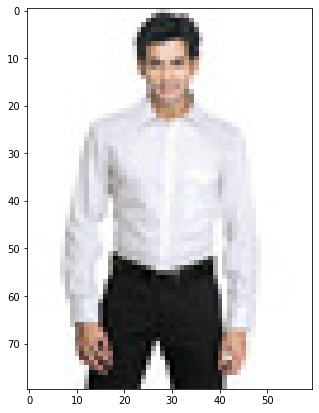

Predicted category:    Topwear (0.297)

Predicted subcategory: Tshirts (0.136)

Predicted attributes:  Casual (0.804)




In [45]:
# 결과 시각화
for i in range(250):
    print(f"Input image {i}:")

    plt.figure(figsize=(7,7))
    plt.imshow(plt.imread(img_list_test[i]))
    plt.show()
    plt.close()

    cat_pred = cat_names[np.argmax(predictions[0][i])]
    cat_pred_score = str(max(predictions[0][i]))[:5]
    
    subcat_pred = subcat_names[np.argmax(predictions[1][i])]
    subcat_pred_score = str(max(predictions[1][i]))[:5]
    
    attr_preds = attribute_names[np.where(predictions[2][i] > 0.7)]
    attr_pred_scores = np.around(predictions[2][i][np.where(predictions[2][i] > 0.7)],3)

    print(f"Predicted category:    {cat_pred} ({cat_pred_score})")
    print()
    
    print(f"Predicted subcategory: {subcat_pred} ({subcat_pred_score})")
    print()

    print("Predicted attributes: ", ", ".join("{} ({})".format(x, str(y)[:5]) for x, y in zip(attr_preds, attr_pred_scores)))
    print()
    print()

In [46]:
df_2 = pd.read_csv(os.path.join(os.getcwd(), 'styles.csv'),error_bad_lines=False)
df_2.head()

C:\Users\Sangwoo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expe

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

# 모델의 비교를 위해 kaggle에 submit된 다른 code 활용 (1)

In [47]:
df_2 = df_2.dropna()
df_2.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [48]:
cat_columns = ['gender', 'masterCategory', 'subCategory', 'articleType','baseColour', 'season', 'year', 'usage']
for col in cat_columns:
    print(col)
    print(df_2[col].unique())
    print('-------------------------')

gender
['Men' 'Women' 'Boys' 'Girls' 'Unisex']
-------------------------
masterCategory
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
-------------------------
subCategory
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
-------------------------
articleType
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lips

# 적은 데이터 수 제거
   - subCategory의 속성에서 500개 미만인 속성들 제거
   - articleType의 속성에서 500개 미만인 속성들 제거

In [49]:
value_counts = df_2['subCategory'].value_counts()

indexes = value_counts.index
values = value_counts.values
for i in range(len(value_counts)):
    if values[i] < 500:
        break

sub_types_used = indexes[:i]
print('subCategory types used: ',sub_types_used)

subCategory types used:  Index(['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches', 'Innerwear',
       'Jewellery', 'Eyewear', 'Fragrance', 'Sandal', 'Wallets', 'Flip Flops',
       'Belts', 'Socks'],
      dtype='object')


In [50]:
value_counts = df_2['articleType'].value_counts()

indexes = value_counts.index
values = value_counts.values
for i in range(len(value_counts)):
    if values[i] < 500:
        break

art_types_used = indexes[:i]
print('articleType types used: ',art_types_used)

articleType types used:  Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes',
       'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets',
       'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks',
       'Formal Shoes', 'Perfume and Body Mist', 'Jeans', 'Shorts', 'Trousers',
       'Flats'],
      dtype='object')


In [51]:
df_2 = df_2[df_2['subCategory'].isin(sub_types_used)]
df_2 = df_2[df_2['articleType'].isin(art_types_used)]

In [52]:
len(df)

44077

In [53]:
# image file명 dataframe에 추가
df_2['image'] = df_2.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df_2 = df_2.sample(frac=1).reset_index(drop=True)
df_2.head(10)

id  gender masterCategory subCategory            articleType baseColour  \
0  43565  Unisex    Accessories        Bags              Backpacks      Black   
1  46779     Men  Personal Care   Fragrance  Perfume and Body Mist     Orange   
2  14769     Men        Apparel     Topwear                 Shirts       Blue   
3   3218     Men       Footwear       Shoes           Casual Shoes      Black   
4  32291     Men    Accessories     Watches                Watches      Black   
5  30070     Men    Accessories     Watches                Watches      Steel   
6   8216  Unisex    Accessories        Bags              Backpacks      Black   
7  27945     Men        Apparel   Innerwear                 Briefs      White   
8   6434     Men       Footwear       Shoes           Casual Shoes      Brown   
9  28393   Women    Accessories     Eyewear             Sunglasses      Brown   

   season    year   usage                                 productDisplayName  \
0  Summer  2012.0  Casual                    Puma Unisex Black Echo Backpack   
1  Spring  2017.0  Casual                         Euroluxe Men Frank Perfume   
2    Fall  2011.0  Formal                      Arrow Men Stripes Blue Shirts   
3    Fall  2010.0  Casual         Puma Men's Yacht Battleship Black Red Shoe   
4  Winter  2016.0  Casual                           Q&Q Men Black Dial Watch   
5  Winter  2016.0  Casual                     Ed Hardy Men Silver Dial Watch   
6  Winter  2016.0  Casual  Fastrack Unisex Black Orange Single Strap Back...   
7  Summer  2016.0  Casual      Jockey Men Comfort Stretch White Bikini Brief   
8  Summer  2011.0  Casual                      Lotto Men's Canvas Khaki Shoe   
9  Winter  2016.0  Casual                        Idee Women Brown Sunglasses   

       image  
0  43565.jpg  
1  46779.jpg  
2  14769.jpg  
3   3218.jpg  
4  32291.jpg  
5  30070.jpg  
6   8216.jpg  
7  27945.jpg  
8   6434.jpg  
9  28393.jpg

In [54]:
# batch_size 32로 설정
batch_size = 32

In [55]:
data = []

# image들을 다 불러와서 읽고 저장
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

IX = 80
IY = 60
invalid_ids = []
for name in df.id:
    try:
        image = cv2.imread(os.path.join(os.getcwd(), 'images', str(name) + '.jpg'))
        image = cv2.resize(image, (IX, IY))
        image = img_to_array(image)
        data.append(image)        
    except: 
        # image data가 없는 record 제외
        invalid_ids.append(name)

In [56]:
print('invalid ids:')
print(invalid_ids)

invalid ids:
[39403, 39410, 39401, 39425, 12347]


In [57]:
# image data로 subCategory, articleType 구분
labels = []
used_columns = ['subCategory', 'articleType']

# subCategory, articleType 속성들의 labels 추출
for index, row in df.iterrows():
    if row['id'] in invalid_ids:
        continue

    tags = []
    for col in used_columns:
        tags.append(row[col])

    labels.append(tags)

In [58]:
# image 전처리 진행
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(labels)

[['Topwear' 'Shirts']
 ['Bottomwear' 'Jeans']
 ['Watches' 'Watches']
 ...
 ['Topwear' 'Tshirts']
 ['Fragrance' 'Perfume and Body Mist']
 ['Watches' 'Watches']]


In [59]:
from sklearn.preprocessing import MultiLabelBinarizer

# 여러 클래스들의 구분하기 위해 수치화
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

print(mlb.classes_)
print(labels[0])

['Accessories' 'Accessory Gift Set' 'Apparel Set' 'Baby Dolls' 'Backpacks'
 'Bags' 'Bangle' 'Basketballs' 'Bath Robe' 'Bath and Body'
 'Beauty Accessories' 'Beauty Accessory' 'Belts' 'Blazers' 'Body Lotion'
 'Body Wash and Scrub' 'Booties' 'Bottomwear' 'Boxers' 'Bra' 'Bracelet'
 'Briefs' 'Camisoles' 'Capris' 'Caps' 'Casual Shoes' 'Churidar'
 'Clothing Set' 'Clutches' 'Compact' 'Concealer' 'Cufflinks'
 'Cushion Covers' 'Deodorant' 'Dress' 'Dresses' 'Duffel Bag' 'Dupatta'
 'Earrings' 'Eye Cream' 'Eyes' 'Eyeshadow' 'Eyewear' 'Face Moisturisers'
 'Face Scrub and Exfoliator' 'Face Serum and Gel' 'Face Wash and Cleanser'
 'Flats' 'Flip Flops' 'Footballs' 'Formal Shoes' 'Foundation and Primer'
 'Fragrance' 'Fragrance Gift Set' 'Free Gifts' 'Gloves' 'Hair'
 'Hair Accessory' 'Hair Colour' 'Handbags' 'Hat' 'Headband' 'Headwear'
 'Heels' 'Highlighter and Blush' 'Home Furnishing' 'Innerwear'
 'Innerwear Vests' 'Ipad' 'Jackets' 'Jeans' 'Jeggings' 'Jewellery'
 'Jewellery Set' 'Jumpsuit' 'Kajal and E

# 모델 구현
   - image의 크기가 작고 범주가 극명하게 구별되기 때문에 간단한 순차 모델 사용
   - image를 입력값으로 subCategory, articleType만 구분
   - 출력 layer의 활성화 함수를 sigmoid 사용 -> 아까 labels들을 binary화 시킴
   - loss function은 binary crossentropy 사용

In [60]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

inputShape = (IY, IX, 3)

# 이미지가 해상도가 매우 낮고 범주가 극명하게 구별되기 때문에 매우 간단한 순차 모델이 사용
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten()) 
model_2.add(Dense(128))
model_2.add(Activation('sigmoid'))

out = len(mlb.classes_)

model_2.add(Dense(out))
model_2.add(Activation('sigmoid'))
                    
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [61]:
from sklearn.model_selection import train_test_split

# train, test set split -> train dataset 90% test dataset 10%
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.1, random_state=42)

# 모델 학습
   - epochs을 50으로 진행
   - 성능은 마지막에 종합적으로 비교

In [62]:
epochs = 50

#training the model 
model_2.fit(x=trainX, y=trainY,
          epochs=epochs ,verbose=1)

Train on 39664 samples
Epoch 1/50
39664/39664 [==============================] - 26s 664us/sample - loss: 0.0530 - acc: 0.9874 - loss: 0.0530 - acc: 0.9
Epoch 2/50
39664/39664 [==============================] - 25s 633us/sample - loss: 0.0424 - acc: 0.9891
Epoch 3/50
39664/39664 [==============================] - 26s 645us/sample - loss: 0.0424 - acc: 0.9891
Epoch 4/50
39664/39664 [==============================] - 26s 652us/sample - loss: 0.0424 - acc: 0.9891
Epoch 5/50
39664/39664 [==============================] - 26s 656us/sample - loss: 0.0424 - acc: 0.9891 
Epoch 6/50
39664/39664 [==============================] - 26s 661us/sample - loss: 0.0424 - acc: 0.9891 - los
Epoch 7/50
39664/39664 [==============================] - 27s 669us/sample - loss: 0.0424 - acc: 0.9891
Epoch 8/50
39664/39664 [==============================] - 26s 668us/sample - loss: 0.0424 - acc: 0.9891
Epoch 9/50
39664/39664 [==============================] - 27s 671us/sample - loss: 0.0424 - acc: 0.9891
Epoch 10

# 모델의 비교를 위해 kaggle에 submit된 다른 code 활용 (2)
   - 이번엔 3가지의 클래스 classify하는 것을 진행
   - masterCategory, subCategory, articleType 3가지의 속성 사용
   - 나머지 과정들은 위와 동일

In [73]:
label = []
used_columns = ['masterCategory', 'subCategory', 'articleType']

for index, row in df.iterrows():
    if row['id'] in invalid_ids:
        continue

    tags = []
    for col in used_columns:
        tags.append(row[col])

    label.append(tags)

In [74]:
label = np.array(label)

print(label)

[['Apparel' 'Topwear' 'Shirts']
 ['Apparel' 'Bottomwear' 'Jeans']
 ['Accessories' 'Watches' 'Watches']
 ...
 ['Apparel' 'Topwear' 'Tshirts']
 ['Personal Care' 'Fragrance' 'Perfume and Body Mist']
 ['Accessories' 'Watches' 'Watches']]


In [76]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
label = mlb.fit_transform(label)

print(mlb.classes_)
print(label[0])

['Accessories' 'Accessory Gift Set' 'Apparel' 'Apparel Set' 'Baby Dolls'
 'Backpacks' 'Bags' 'Bangle' 'Basketballs' 'Bath Robe' 'Bath and Body'
 'Beauty Accessories' 'Beauty Accessory' 'Belts' 'Blazers' 'Body Lotion'
 'Body Wash and Scrub' 'Booties' 'Bottomwear' 'Boxers' 'Bra' 'Bracelet'
 'Briefs' 'Camisoles' 'Capris' 'Caps' 'Casual Shoes' 'Churidar'
 'Clothing Set' 'Clutches' 'Compact' 'Concealer' 'Cufflinks'
 'Cushion Covers' 'Deodorant' 'Dress' 'Dresses' 'Duffel Bag' 'Dupatta'
 'Earrings' 'Eye Cream' 'Eyes' 'Eyeshadow' 'Eyewear' 'Face Moisturisers'
 'Face Scrub and Exfoliator' 'Face Serum and Gel' 'Face Wash and Cleanser'
 'Flats' 'Flip Flops' 'Footballs' 'Footwear' 'Formal Shoes'
 'Foundation and Primer' 'Fragrance' 'Fragrance Gift Set' 'Free Gifts'
 'Free Items' 'Gloves' 'Hair' 'Hair Accessory' 'Hair Colour' 'Handbags'
 'Hat' 'Headband' 'Headwear' 'Heels' 'Highlighter and Blush' 'Home'
 'Home Furnishing' 'Innerwear' 'Innerwear Vests' 'Ipad' 'Jackets' 'Jeans'
 'Jeggings' 'Jewellery

In [77]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

inputShape = (IY, IX, 3)

model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten()) 
model_3.add(Dense(128))
model_3.add(Activation('sigmoid'))

out = len(mlb.classes_)

model_3.add(Dense(out))
model_3.add(Activation('sigmoid'))
                    
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
from sklearn.model_selection import train_test_split

# train, test set split -> train dataset 90% test dataset 10%
(trainX, testX, trainY, testY) = train_test_split(data, label, test_size=0.1, random_state=43)

In [79]:
epochs = 50
 
model_3.fit(x=trainX, y=trainY,
          epochs=epochs ,verbose=1)

Train on 39664 samples
Epoch 1/50
39664/39664 [==============================] - 25s 633us/sample - loss: 5903053817.8354 - acc: 0.1785
Epoch 2/50
39664/39664 [==============================] - 25s 630us/sample - loss: 117138479208.9197 - acc: 0.1856
Epoch 3/50
39664/39664 [==============================] - 26s 650us/sample - loss: 504413640792.3970 - acc: 0.1846
Epoch 4/50
39664/39664 [==============================] - 26s 665us/sample - loss: 1251586042646.6155 - acc: 0.1865 - loss: 1 - ETA: 0s - loss: 1248587643019.4456 - acc
Epoch 5/50
39664/39664 [==============================] - 27s 690us/sample - loss: 2529051280787.5693 - acc: 0.1843
Epoch 6/50
39664/39664 [==============================] - 28s 705us/sample - loss: 4519149127832.8359 - acc: 0.1863 - loss: 444811
Epoch 7/50
39664/39664 [==============================] - 29s 724us/sample - loss: 7541279076396.6113 - acc: 0.1856
Epoch 8/50
39664/39664 [==============================] - 29s 731us/sample - loss: 11365672307607.4941

# 종합적인 성능 비교
   - 첫 번째로 진행한 모델 : 계층적인 클래스 구조를 사용하여 구분하기 위해 학습한 모델
   - 두 번째로 진행한 모델 : 계층적인 클래스 구조로 보지 않고 하나의 속성으로 2개의 클래스를 하나로 합쳐 학습한 모델
   - 세 번째로 진행한 모델 : 계층적인 클래스 구조로 보지 않고 하나의 속성으로 3개의 클래스를 하나로 합쳐 학습한 모델
   
    
   - 첫 번째로 진행한 모델 성능 : subCategory accuracy 약 30% articleType accuracy 약 15% attributes accuracy 약 92%
   - 두 번째로 진행한 모델 성능 : subCategory, articleType accuracy 약 99%
   - 세 번째로 진행한 모델 성능 : masterCategory, subCategory, articleType accuracy 약 48%

In [66]:
total = model.evaluate_generator(test_generator)

In [82]:
print('subCategory accuracy : ', str(total[4]))
print('articleType accuracy : ', str(total[5]))
print('attributes accuracy : ', str(total[6]))

subCategory accuracy :  0.28841543197631836
articleType accuracy :  0.14513981342315674
attributes accuracy :  0.9118508696556091


In [69]:
results = model_2.evaluate(testX, testY, batch_size=32)

4408/4408 [==============================] - 2s 366us/sample - loss: 0.0426 - acc: 0.9892


In [83]:
print('subCategory, articleType accuracy : ', str(results[1]))

subCategory, articleType accuracy :  0.9891546


In [80]:
result = model_3.evaluate(testX, testY, batch_size=32)

4408/4408 [==============================] - 3s 570us/sample - loss: 5920105402151826.0000 - acc: 0.4803


In [84]:
print('masterCategory, subCategory, articleType accuracy : ', str(result[1]))

masterCategory, subCategory, articleType accuracy :  0.48026314
